##Purpose:

This brings in .CSV files of user ITEM, Review Scores and uses keras to generate weights (dot product factorization machine). Then we re-use those weights to Cluster both users and Animes. 
We do this in Keras primarily for performance, by using keras we can have this computation done in GPU. 
The fot product neural net used for this fairly simple for the clustering step. But it will become more complex later once we start adding in more inputs (such as the status category)

In [31]:
import numpy as np
from keras import backend as K
from keras.layers import Input, Embedding, merge
import keras.layers
from keras.regularizers import l2, l1
from keras.layers.core import Flatten, Dense, Dropout, Lambda
from keras.models import Sequential, Model
from keras.optimizers import SGD, RMSprop, Adam
from keras.utils import plot_model
from IPython.display import SVG
from sklearn.metrics import pairwise_distances
from scipy import sparse
from sklearn.metrics.pairwise import cosine_similarity

In [3]:
import pandas as pd

In [4]:
csvtoload = 'animeedascores.csv'# This is a subset of reviews 0's included. 

In [5]:
ratings = pd.read_csv(csvtoload) # This is a subset of reviews with all 0's dropped. 
ratings['userid']=ratings['index']
ratings['score']=ratings['animescore']

In [6]:
ratings.tail()

Unnamed: 0  Unnamed: 0.1  animeid  animescore     index      name  \
8989062     8989062       1087163     6201           0  Kathelle  Kathelle   
8989063     8989063       1087164     5277           0  Kathelle  Kathelle   
8989064     8989064       1087165      100           0  Kathelle  Kathelle   
8989065     8989065       1087166     7705           0  Kathelle  Kathelle   
8989066     8989066       1087167     4752           0  Kathelle  Kathelle   

          status         unkey    userid  score  
8989062  BACKLOG  6201Kathelle  Kathelle      0  
8989063  BACKLOG  5277Kathelle  Kathelle      0  
8989064  BACKLOG   100Kathelle  Kathelle      0  
8989065  BACKLOG  7705Kathelle  Kathelle      0  
8989066  BACKLOG  4752Kathelle  Kathelle      0

In [7]:
ratings = ratings[ratings['score']!=0]# if 0's aren't dropped, the prediction engine will start to predict 0's for shows that are frequently not completed. 


In [8]:
ratings = ratings[ratings['status']=='COMPLETED']

In [10]:
# optional block, 
useravg =ratings.groupby('userid').mean()
useravgdict = {}
for user in useravg.index.values:
    score=useravg.loc[user,'score']
    useravgdict[user]=score
ratings['useravg']= ratings.userid.map(useravgdict) 
ratings['score_scaled']=ratings['score']-ratings['useravg']

In [11]:
ratings.head()

Unnamed: 0  Unnamed: 0.1  animeid  animescore           index  \
12          12            12     6547           8  SeinfeldHentai   
13          13            13      889           9  SeinfeldHentai   
14          14            14        1          10  SeinfeldHentai   
15          15            15     2025           9  SeinfeldHentai   
16          16            16    28907           9  SeinfeldHentai   

              name     status                unkey          userid  score  \
12  SeinfeldHentai  COMPLETED   6547SeinfeldHentai  SeinfeldHentai      8   
13  SeinfeldHentai  COMPLETED    889SeinfeldHentai  SeinfeldHentai      9   
14  SeinfeldHentai  COMPLETED      1SeinfeldHentai  SeinfeldHentai     10   
15  SeinfeldHentai  COMPLETED   2025SeinfeldHentai  SeinfeldHentai      9   
16  SeinfeldHentai  COMPLETED  28907SeinfeldHentai  SeinfeldHentai      9   

    useravg  score_scaled  
12    9.125        -1.125  
13    9.125        -0.125  
14    9.125         0.875  
15    9.125        -0.125  
16    9.125        -0.125

There are data sanitziation questions to ask here. One is how to handle status codes, the other is how to handle how normalized the non zero scores are. 0's in this dataset can mean that the user hadn't given a rating. 

In [12]:
users = ratings.userid.unique()
animes = ratings.animeid.unique()

We need a unique list of users and of animes. 

In [13]:
userid2idx = {o:i for i,o in enumerate(users)} # turn the user strings into a numerical value. 
animeid2idx = {o:i for i,o in enumerate(animes)} # remove missing anime numbers and re-order

In [14]:
ratings['anime_id'] = ratings.animeid.apply(lambda x: animeid2idx[x]) #the above code set up mapping, this applies it. 
ratings.userid = ratings.userid.apply(lambda x: userid2idx[x])# the above code set up mapping, this applies it. 
#ratings['anime_id']= ratings['animeid']

In [11]:
ratings.head()

Unnamed: 0  Unnamed: 0.1  animeid  animescore           index  \
12          12            12     6547           8  SeinfeldHentai   
13          13            13      889           9  SeinfeldHentai   
14          14            14        1          10  SeinfeldHentai   
15          15            15     2025           9  SeinfeldHentai   
16          16            16    28907           9  SeinfeldHentai   

              name     status                unkey  userid  score  anime_id  
12  SeinfeldHentai  COMPLETED   6547SeinfeldHentai       0      8         0  
13  SeinfeldHentai  COMPLETED    889SeinfeldHentai       0      9         1  
14  SeinfeldHentai  COMPLETED      1SeinfeldHentai       0     10         2  
15  SeinfeldHentai  COMPLETED   2025SeinfeldHentai       0      9         3  
16  SeinfeldHentai  COMPLETED  28907SeinfeldHentai       0      9         4

It's important to note that anime_id and userid count up from 0.  If we use animeid rather than anime_id in any of the following code things will break (exploding gradients) 

In [15]:
user_min, user_max, anime_min, anime_max = (ratings.userid.min(), 
    ratings.userid.max(), ratings.animeid.min(), ratings.animeid.max())
user_min, user_max, anime_min, anime_max

(0, 69535, 1, 35932)

In [16]:
n_users = ratings.userid.nunique()
n_animes = ratings.anime_id.nunique()
n_users, n_animes

(69536, 10086)

Next we decide how many latent factors to use. We'll only know if we have too few or too many once we start looking at the weights later. If the factors are interpretable (with or without pca) we'll know we have a good number. 

In [244]:
n_factors = 32

In [245]:
msk = np.random.rand(len(ratings)) < 0.8 #training vs test set ratio
trn = ratings[msk]
val = ratings[~msk]

In [246]:
user_in = Input(shape=(1,), dtype='int64', name='user_id_in')
u = Embedding(n_users, n_factors, input_length=1, embeddings_regularizer=l2(.05),name='Embed_User_Hidden_Factors')(user_in)
anime_in = Input(shape=(1,), dtype='int64', name='anime_id_in')
m = Embedding(n_animes, n_factors, input_length=1, embeddings_regularizer=l2(0),name='Embed_Anime_Hidden_Factors')(anime_in)

In [247]:
x = keras.layers.dot([u, m], axes=2,name='DotProduct')
#x = merge([u, m], mode='dot')
x = Flatten()(x)
model = Model([user_in, anime_in], x)
model.compile(Adam(0.001), loss='mae')

In [248]:
model.lr=.5

In [249]:
model.fit([trn.userid, trn.anime_id], trn.score_scaled, batch_size=5120, epochs=8, 
          validation_data=([val.userid, val.anime_id], val.score_scaled)) # we want to set the batch size to the max the gpu can handle. This is a gtx 1060 6b

Train on 3453182 samples, validate on 862757 samples
Epoch 1/8
3453182/3453182 [==============================] - 7s - loss: 3.0296 - val_loss: 1.0333
Epoch 2/8
3453182/3453182 [==============================] - 7s - loss: 1.0314 - val_loss: 1.0333
Epoch 3/8
3453182/3453182 [==============================] - 7s - loss: 1.0314 - val_loss: 1.0333
Epoch 4/8
3453182/3453182 [==============================] - 7s - loss: 1.0314 - val_loss: 1.0333
Epoch 5/8
3453182/3453182 [==============================] - 7s - loss: 1.0314 - val_loss: 1.0334
Epoch 6/8
3453182/3453182 [==============================] - 7s - loss: 1.0314 - val_loss: 1.0334
Epoch 7/8
3453182/3453182 [==============================] - 7s - loss: 1.0314 - val_loss: 1.0334
Epoch 8/8
3453182/3453182 [==============================] - 7s - loss: 1.0315 - val_loss: 1.0334


In [187]:
#model.lr=.1

In [188]:
#model.fit([trn.userid, trn.anime_id], trn.score, batch_size=5120, epochs=18, 
#          validation_data=([val.userid, val.anime_id], val.score))

In [189]:
#plot_model(model, to_file='dot22.png')

In [190]:
#model.save_weights('latentfactorslogical.h2a')

We can see that we have begun to overfit. 
However, the point of these latent factors is not (yet) to make predictions, but to check the latent factors to see what that tells us about anime. 
It's important to note several things at this point. 
The first is that if we wanted to improve our MAE/MSE we would add bias terms (which we will later). We are intentionally leaving out bias terms because that forces every anime's user score to be be based entirely on it's latent factors.
The second is that this is an unusual data set to feed into this: The merging of uncompleted / will be watched in the future shows is unusual. 


Anime analysis:
Let's look at some anime and break them into their factors.

In [252]:
g=ratings.groupby('animeid')['score'].count()
topAnime=g.sort_values(ascending=False)[:2500]
topAnime = np.array(topAnime.index) # we're only going to worry about the top 2500 best reviewed anime for now. 


In [253]:
topAnime2 = []

In [254]:
for num in range(len(topAnime)):
    topAnime2.append(animeid2idx[topAnime[num]])

In [255]:
topAnime2 = np.array(topAnime2)

In [256]:
anime_names = pd.read_csv('animeinfo3.csv').set_index('animeid')['name'].to_dict()

In [257]:
get_anime_emb = Model(anime_in, m)
anime_emb = np.squeeze(get_anime_emb.predict([topAnime2]))
anime_emb.shape


(2500, 32)

So now we have N hidden factors for the top 1750 rated anime. 
Let's turn that into a sparse matrix, and do some pairwise distance. 

In [258]:
anime_latentfactors= sparse.csc_matrix(anime_emb)

In [259]:
anime_similaritycos = cosine_similarity(anime_latentfactors)
latentfactor_similaritycos = cosine_similarity(anime_latentfactors.T)

In [260]:
anime_similaritypair=pairwise_distances(anime_latentfactors.T, metric='cosine')
latentfactor_similaritypair=pairwise_distances(anime_latentfactors, metric='cosine')

In [261]:
anime_similaritycos.shape

(2500, 2500)

In [262]:
orderednames= pd.DataFrame(topAnime.T)

In [263]:
orderednames['anime'] =orderednames[0].map(anime_names)

In [264]:
anime_sim_cos_df = pd.DataFrame(anime_similaritycos, index =orderednames.anime.values , columns=orderednames.anime.values)
anime_sim_cos_num_df = pd.DataFrame(anime_similaritycos, index =topAnime , columns=topAnime)


In [204]:
#animeinfo3 = pd.read_csv('animeinfo3.csv')

In [265]:
anime_sim_cos_df.head()

Death Note  Shingeki no Kyojin  \
Death Note                          1.000000            0.245196   
Shingeki no Kyojin                  0.245196            1.000000   
Sword Art Online                    0.277085            0.038207   
Fullmetal Alchemist: Brotherhood    0.323805            0.040621   
Angel Beats!                        0.151624            0.109936   

                                  Sword Art Online  \
Death Note                                0.277085   
Shingeki no Kyojin                        0.038207   
Sword Art Online                          1.000000   
Fullmetal Alchemist: Brotherhood         -0.038890   
Angel Beats!                              0.266293   

                                  Fullmetal Alchemist: Brotherhood  \
Death Note                                                0.323805   
Shingeki no Kyojin                                        0.040621   
Sword Art Online                                         -0.038890   
Fullmetal Alchemist: Brotherhood                          1.000000   
Angel Beats!                                             -0.247091   

                                  Angel Beats!  \
Death Note                            0.151624   
Shingeki no Kyojin                    0.109936   
Sword Art Online                      0.266293   
Fullmetal Alchemist: Brotherhood     -0.247091   
Angel Beats!                          1.000000   

                                  Code Geass: Hangyaku no Lelouch  \
Death Note                                               0.454543   
Shingeki no Kyojin                                       0.349913   
Sword Art Online                                         0.018112   
Fullmetal Alchemist: Brotherhood                         0.307943   
Angel Beats!                                             0.250293   

                                  Tokyo Ghoul    Naruto  One Punch Man  \
Death Note                          -0.067007 -0.555178       0.404017   
Shingeki no Kyojin                  -0.053354 -0.168578       0.130899   
Sword Art Online                     0.187502 -0.223696       0.101322   
Fullmetal Alchemist: Brotherhood     0.018896 -0.123632       0.054558   
Angel Beats!                         0.145839 -0.219880      -0.092219   

                                  No Game No Life      ...        \
Death Note                               0.438283      ...         
Shingeki no Kyojin                       0.110704      ...         
Sword Art Online                         0.204342      ...         
Fullmetal Alchemist: Brotherhood        -0.066503      ...         
Angel Beats!                             0.140031      ...         

                                  Mahoraba: Heartful days  \
Death Note                                      -0.124030   
Shingeki no Kyojin                              -0.234458   
Sword Art Online                                 0.040971   
Fullmetal Alchemist: Brotherhood                -0.082168   
Angel Beats!                                     0.416357   

                                  Oneechan ga Kita Special  \
Death Note                                        0.195267   
Shingeki no Kyojin                                0.098756   
Sword Art Online                                  0.146636   
Fullmetal Alchemist: Brotherhood                  0.169336   
Angel Beats!                                      0.066350   

                                  Densetsu no Yuusha no Densetsu: Iris Report  \
Death Note                                                           0.048361   
Shingeki no Kyojin                                                  -0.208449   
Sword Art Online                                                     0.042078   
Fullmetal Alchemist: Brotherhood                                    -0.208574   
Angel Beats!                                                         0.274963   

                                     X-Men  \
Death Note                       -0.

In [266]:
anime_sim_cos_df.loc[:,'Death Note'].sort_values()[-20:]

No Game No Life                                                                     0.438283
Kyousou Giga (TV)                                                                   0.441178
Detective Conan Movie 07: Crossroad in the Ancient Capital                          0.441390
Yami Shibai 3rd Season                                                              0.441815
Kara no Kyoukai 5: Mujun Rasen                                                      0.442580
Abenobashi Mahou☆Shoutengai                                                         0.445367
High School DxD New                                                                 0.445412
Code Geass: Hangyaku no Lelouch                                                     0.454543
The Everlasting Guilty Crown                                                        0.459642
Soukou no Strain                                                                    0.460536
Gintama: Nanigoto mo Saiyo ga Kanjin nano de Tasho Senobisuru Kurai ga

In [267]:
anime_sim_cos_df.loc[:,'Shingeki no Kyojin'].sort_values()[-20:]

.hack//Liminality                                                                   0.423266
Tales of Vesperia: The First Strike                                                 0.426424
BlazBlue: Alter Memory                                                              0.429168
Bokusatsu Tenshi Dokuro-chan 2                                                      0.431143
Big Order (TV)                                                                      0.434181
Kuroshitsuji Recap                                                                  0.435156
Detective Conan Movie 16: The Eleventh Striker                                      0.447589
Hajime no Ippo: Rising                                                              0.449461
Baccano! Specials                                                                   0.449850
Gantz:O                                                                             0.460844
Shokugeki no Souma                                                    

In [268]:
anime_sim_cos_df.loc[:,'Naruto'].sort_values()[-20:]

Kashimashi: Girl Meets Girl                                                     0.434730
One Piece: Umi no Heso no Daibouken-hen                                         0.437103
Kiniro Mosaic                                                                   0.438941
Mind Game                                                                       0.442485
Harmonie                                                                        0.445429
Shakugan no Shana II (Second) Specials                                          0.446143
Seikai no Monshou                                                               0.449475
Shuumatsu Nani Shitemasu ka? Isogashii desu ka? Sukutte Moratte Ii desu ka?     0.453792
.hack//Gift                                                                     0.453940
Berserk: Ougon Jidai-hen II - Doldrey Kouryaku                                  0.454751
Ranma ½                                                                         0.460099
Toaru Kagaku no Railg

In [209]:
anime_sim_cos_df.loc[:,'Fullmetal Alchemist: Brotherhood'].sort_values()[-20:]

Shigatsu wa Kimi no Uso                                  0.998571
Ansatsu Kyoushitsu (TV) 2nd Season                       0.998577
Hunter x Hunter (2011)                                   0.998583
Gintama Movie 2: Kanketsu-hen - Yorozuya yo Eien Nare    0.998583
Shinsekai yori                                           0.998605
Shokugeki no Souma                                       0.998672
Death Note                                               0.998675
Kimi no Na wa.                                           0.998683
Monogatari Series: Second Season                         0.998705
Kotonoha no Niwa                                         0.998719
Toradora!                                                0.998812
Natsume Yuujinchou Shi                                   0.998825
Clannad: After Story                                     0.998836
Gintama'                                                 0.998867
Code Geass: Hangyaku no Lelouch                          0.998901
Haikyuu!! 

In [269]:
anime_sim_cos_df.loc[:,'Bakemonogatari'].sort_values()[-20:]

Photokano                                 0.405491
Kyou no 5 no 2 (TV)                       0.409966
Tantei Gakuen Q                           0.410342
K-On!                                     0.414361
Kakumeiki Valvrave 2nd Season             0.417984
Sakamoto desu ga? Special                 0.439948
Kara no Kyoukai 6: Boukyaku Rokuon        0.441039
Gantz 2nd Stage                           0.442774
Prince of Stride: Alternative             0.443638
Rental Magica                             0.450132
Shakugan no Shana S                       0.450951
Re:Petit kara Hajimeru Isekai Seikatsu    0.461110
Koe no Katachi                            0.464162
Hotarubi no Mori e                        0.464541
Gundam Build Fighters Try                 0.470307
Hakuouki Hekketsuroku                     0.472591
Aldnoah.Zero 2nd Season                   0.480149
Owari no Seraph: Nagoya Kessen-hen        0.485172
Noein: Mou Hitori no Kimi e               0.589056
Bakemonogatari                 

In [270]:
anime_sim_cos_df.loc[:,'Girls und Panzer'].sort_values()[-20:]

Naruto: Akaki Yotsuba no Clover wo Sagase    0.409977
Yozakura Quartet                             0.411173
Kill Me Baby                                 0.412823
Bokusatsu Tenshi Dokuro-chan 2               0.414173
Hoshi wo Ou Kodomo                           0.415377
Higurashi no Naku Koro ni Kira               0.421494
Selector Infected WIXOSS                     0.428322
Shining Tears X Wind                         0.428801
Baka to Test to Shoukanjuu Ni!               0.433537
Kimi ni Todoke 2nd Season: Kataomoi          0.434024
Kaze no Stigma                               0.451190
Gochuumon wa Usagi desu ka?                  0.458014
Panty & Stocking with Garterbelt             0.489252
Kuragehime                                   0.489983
Schwarzesmarken                              0.490278
Piano no Mori                                0.493865
Giniro no Kami no Agito                      0.504392
Cardcaptor Sakura Specials                   0.610513
Seikon no Qwaser II         

In [212]:
from sklearn.decomposition import PCA
pca = PCA(n_components=16)
anime_pca = pca.fit(anime_emb.T).components_

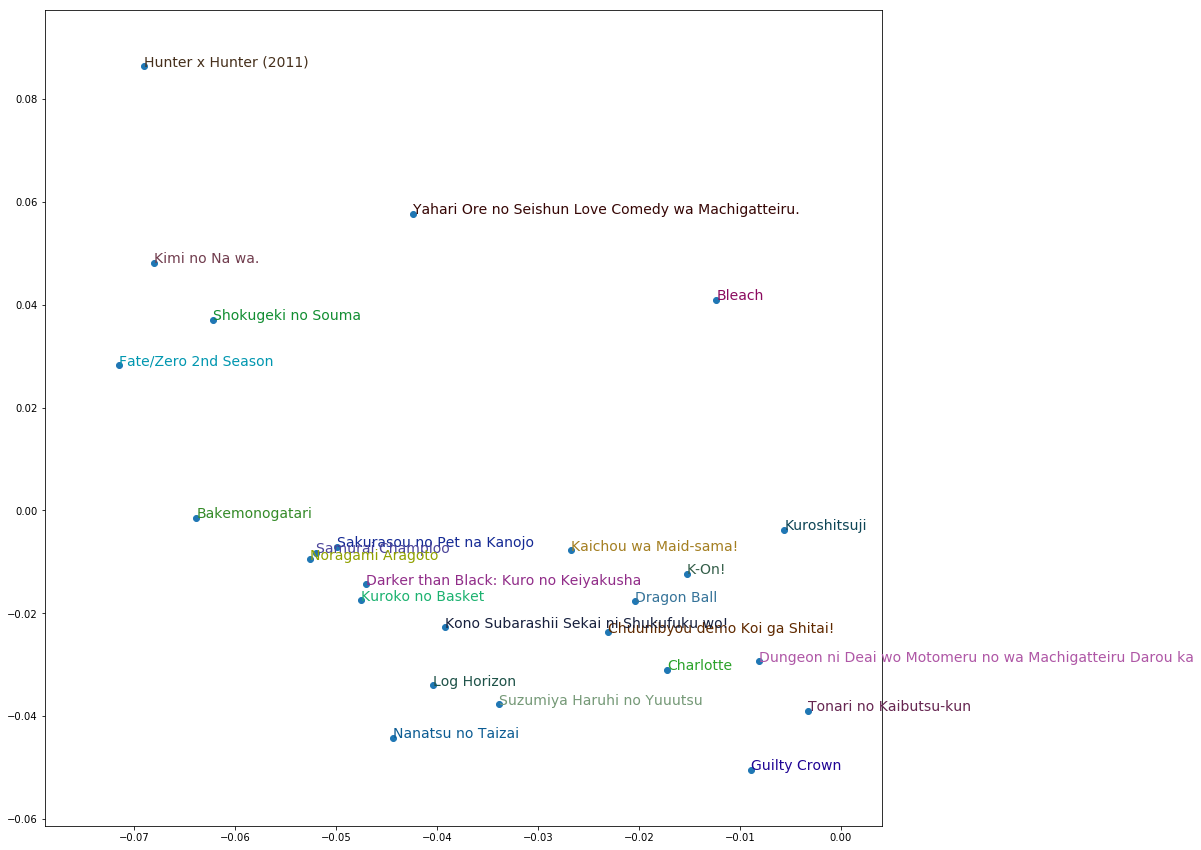

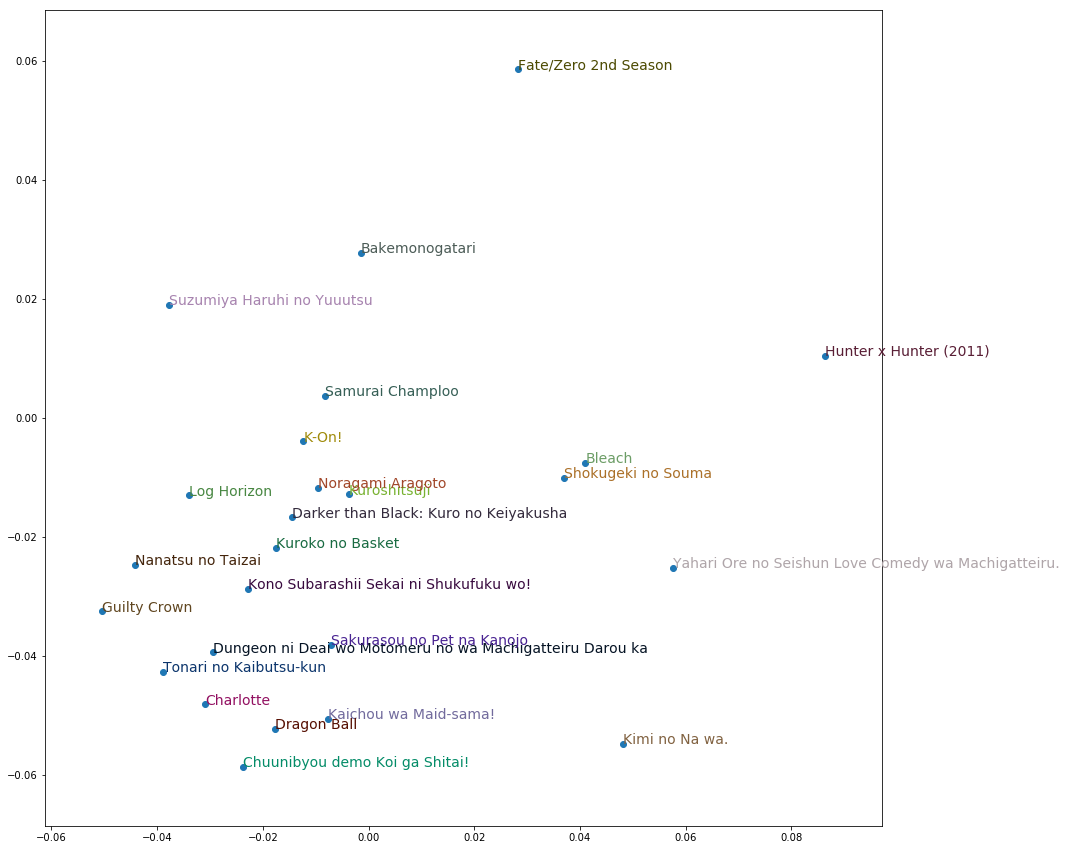

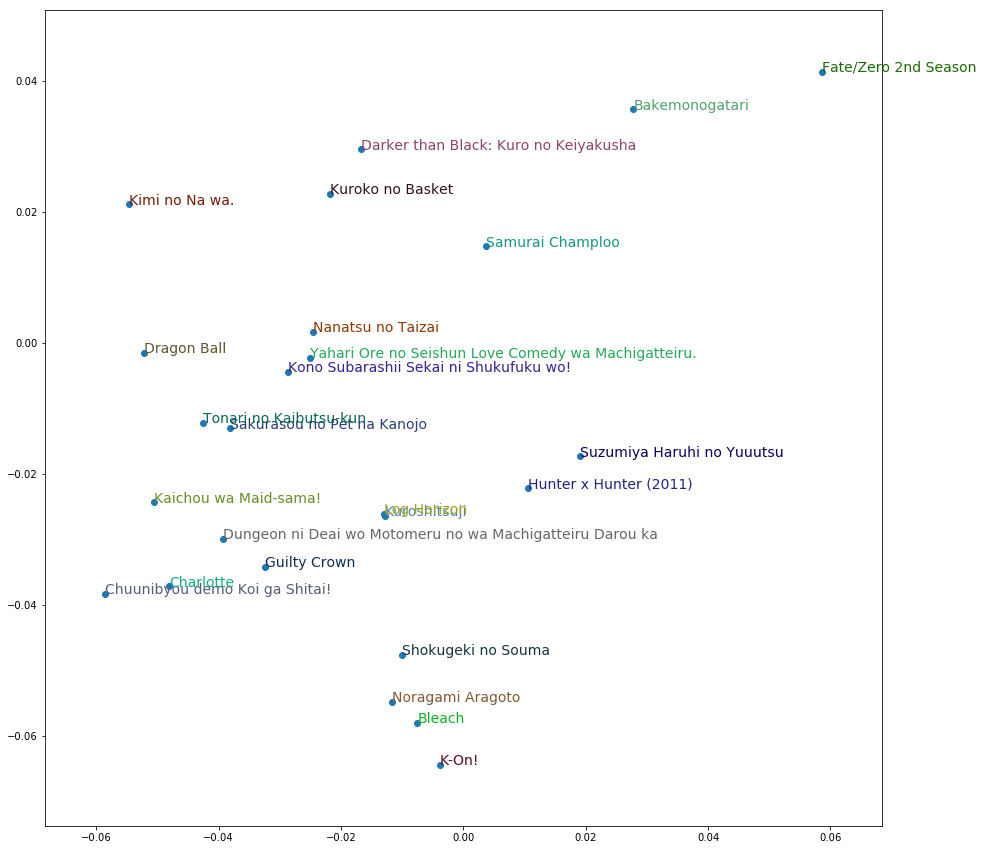

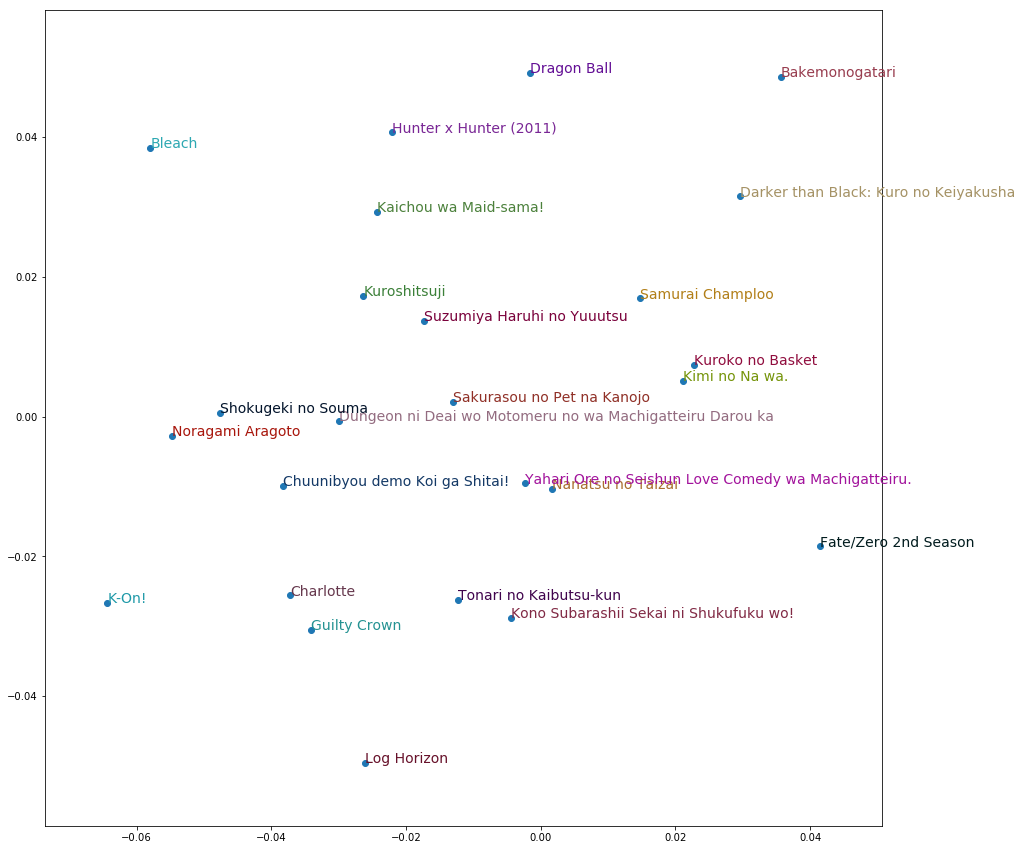

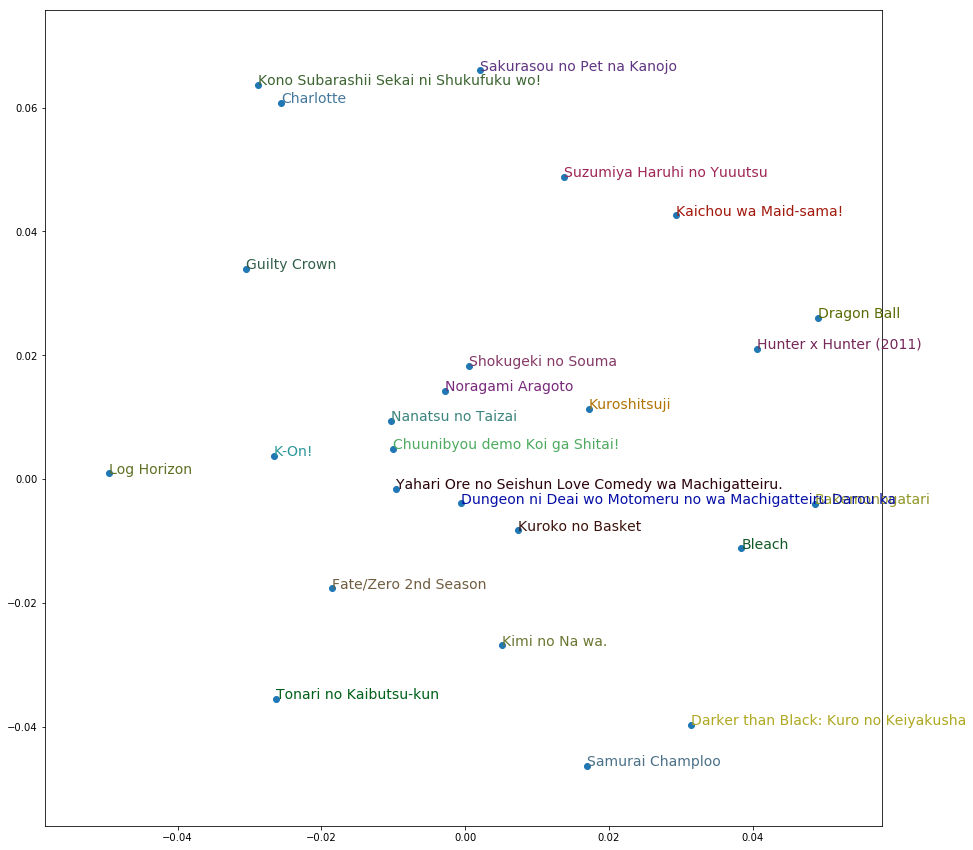

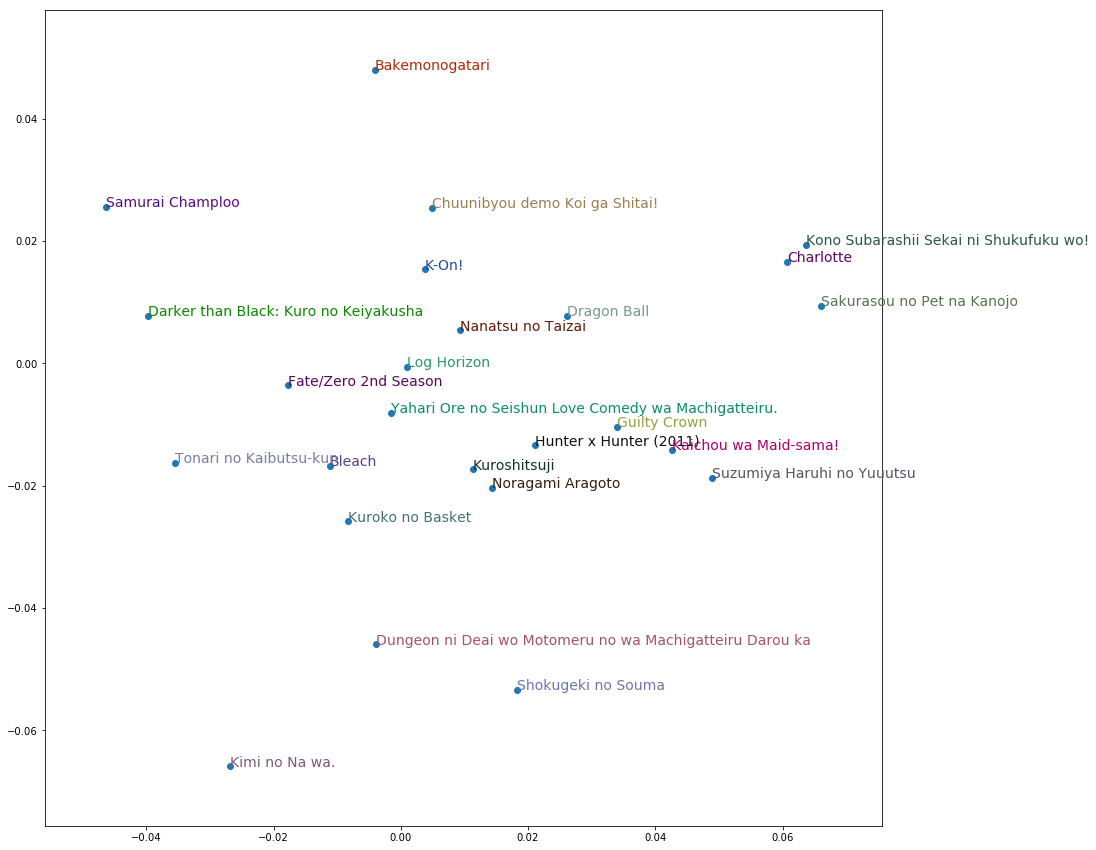

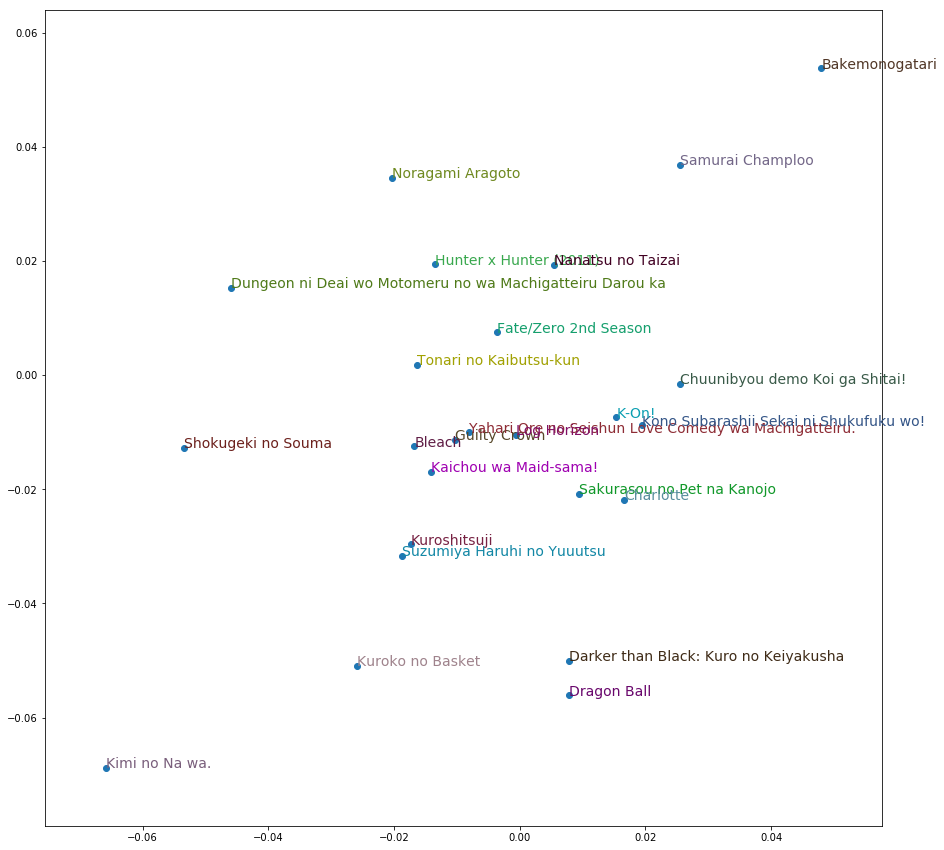

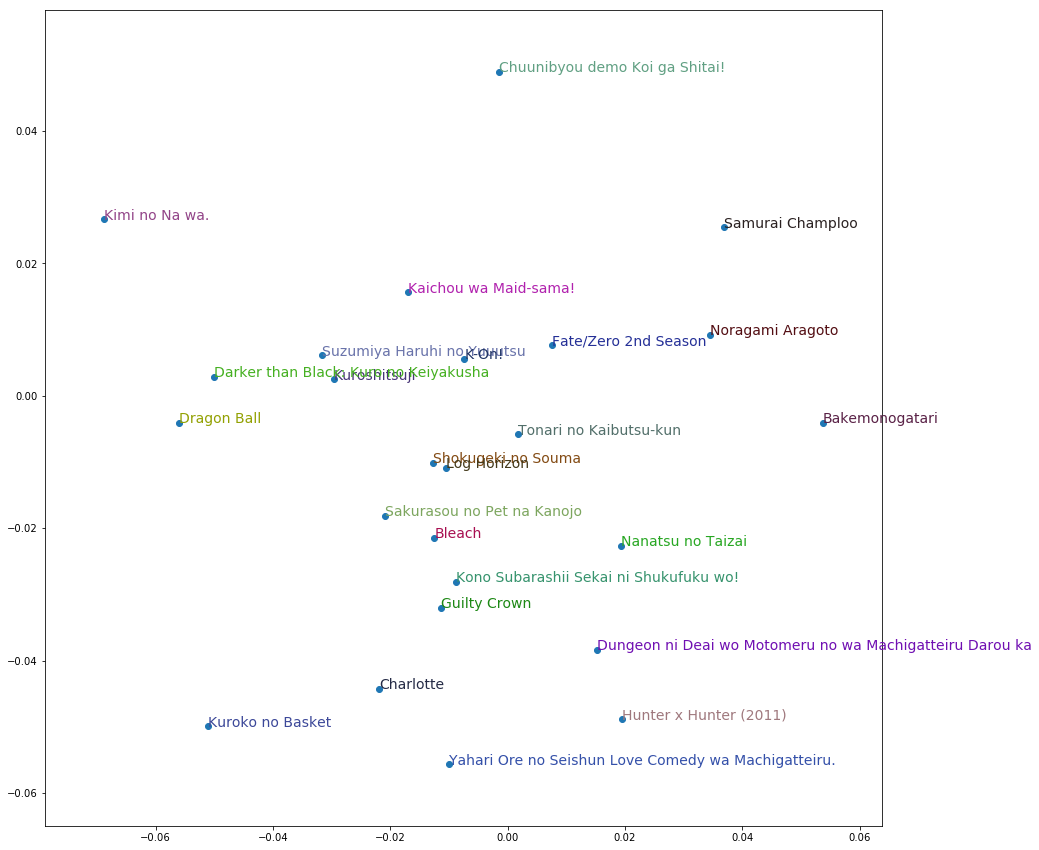

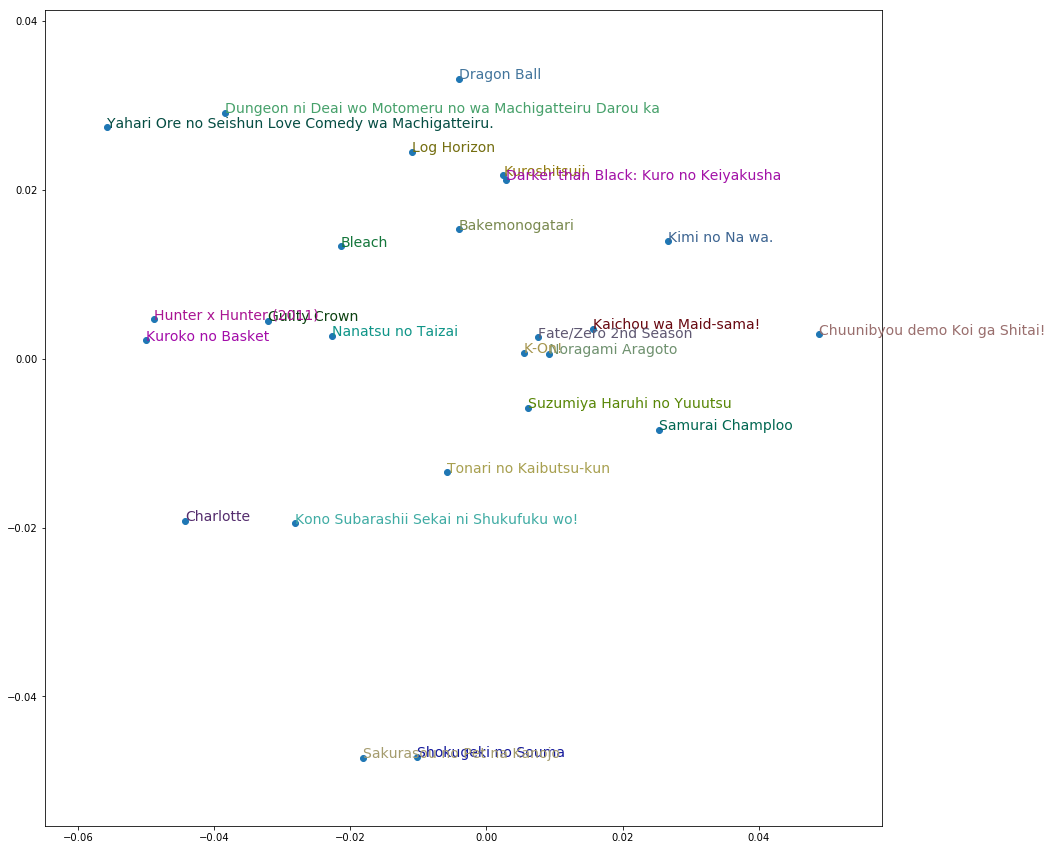

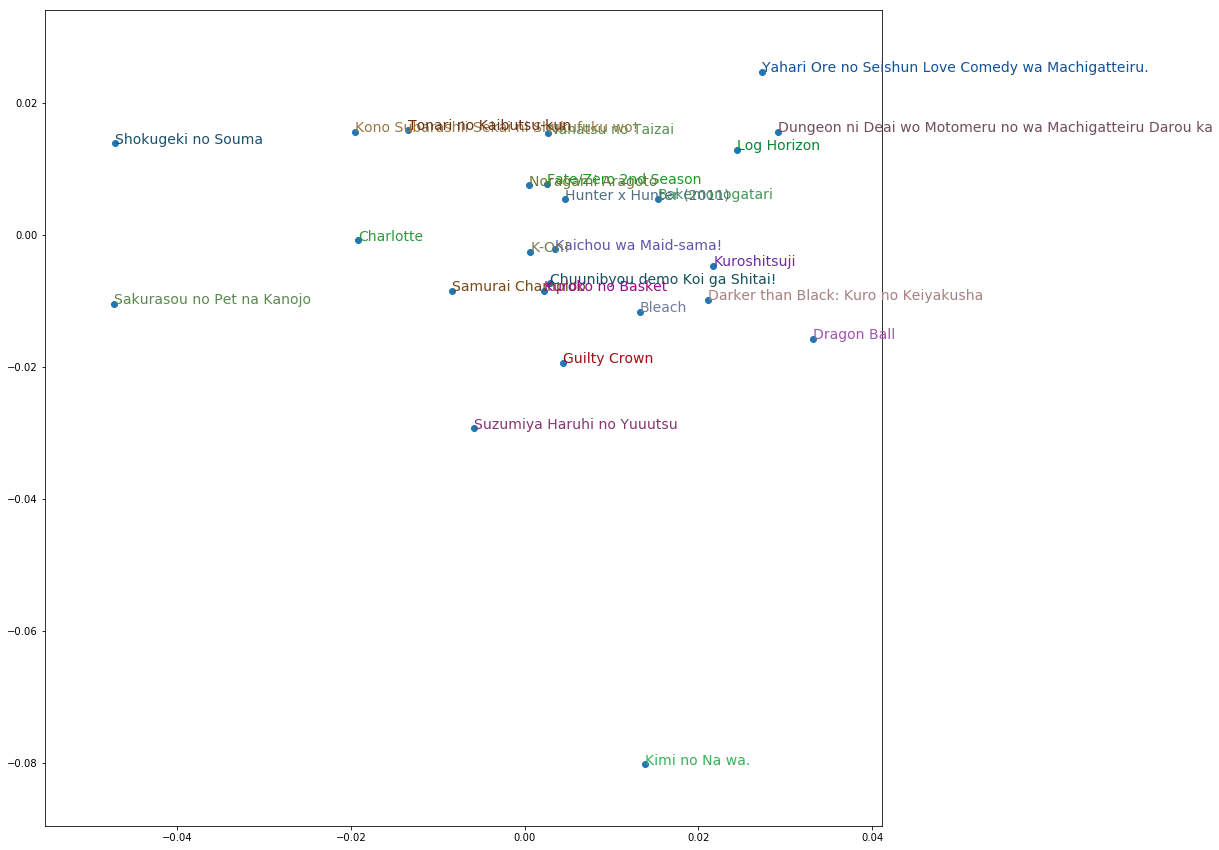

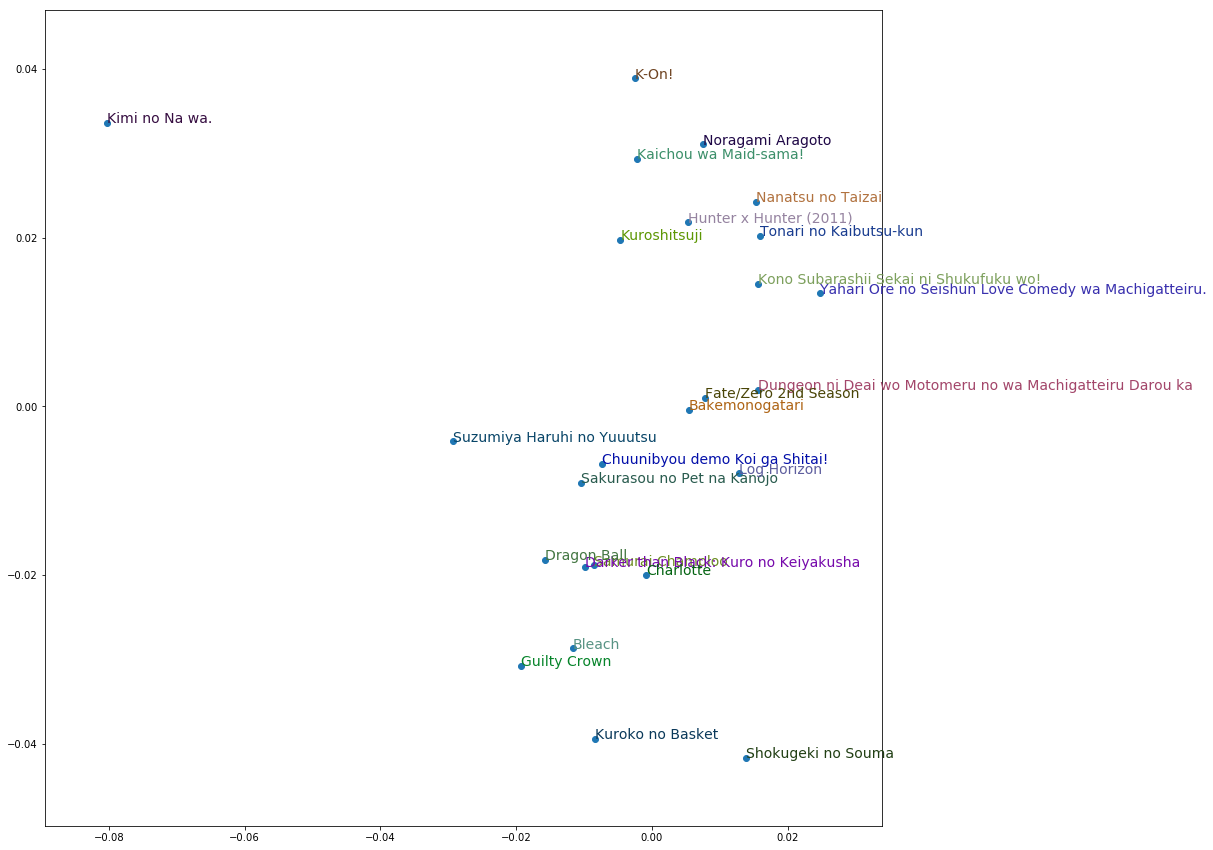

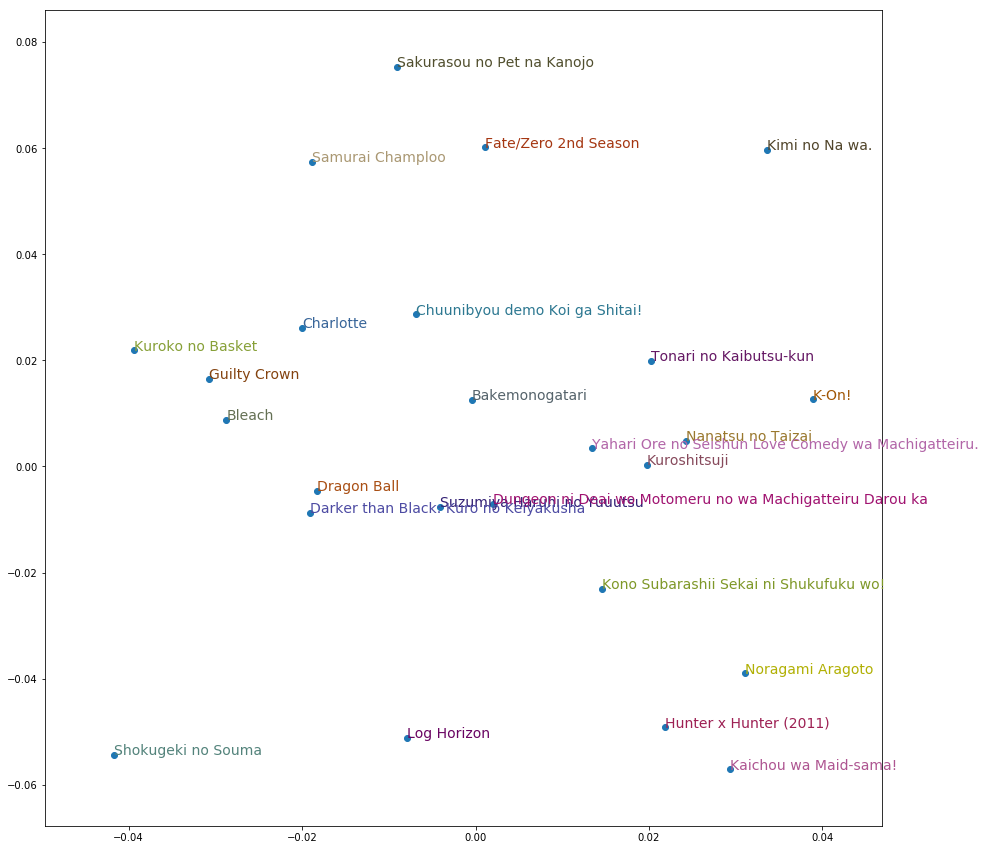

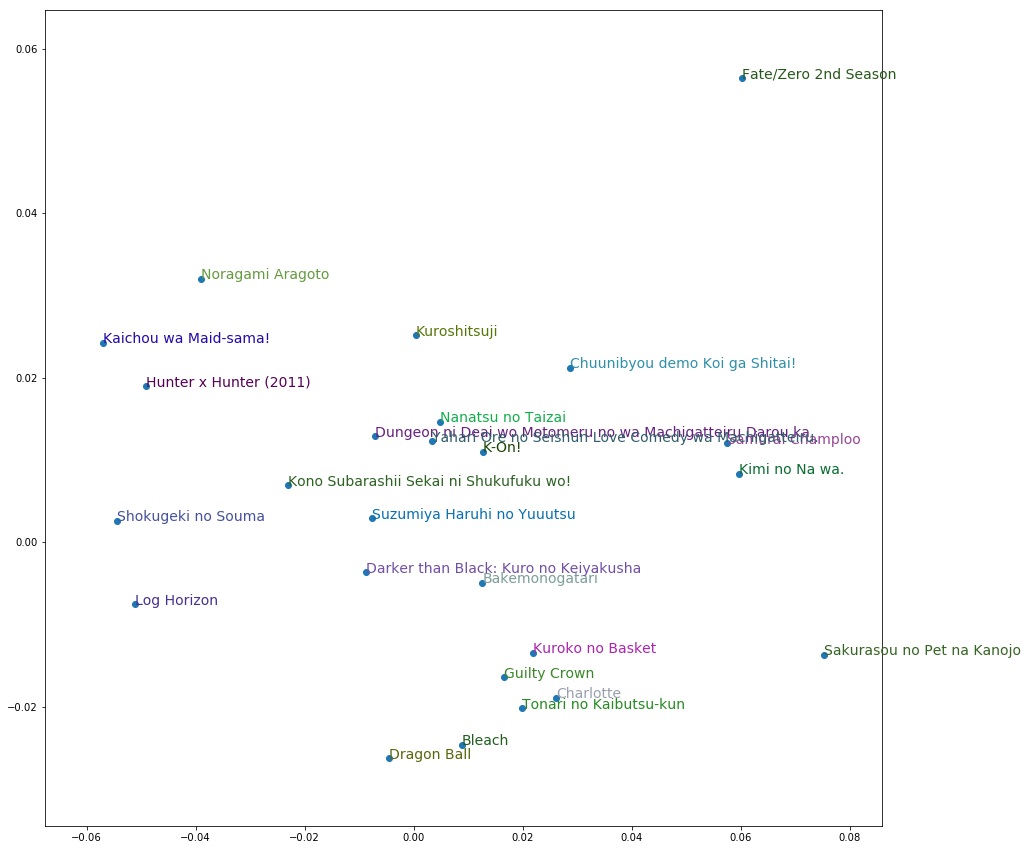

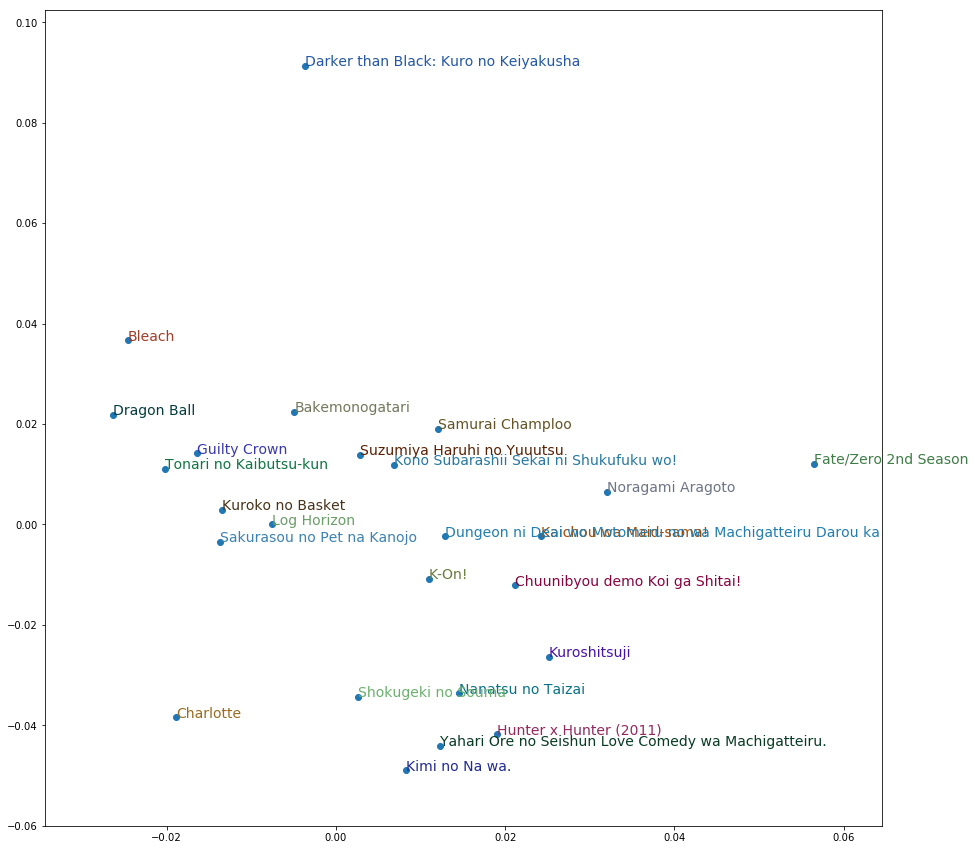

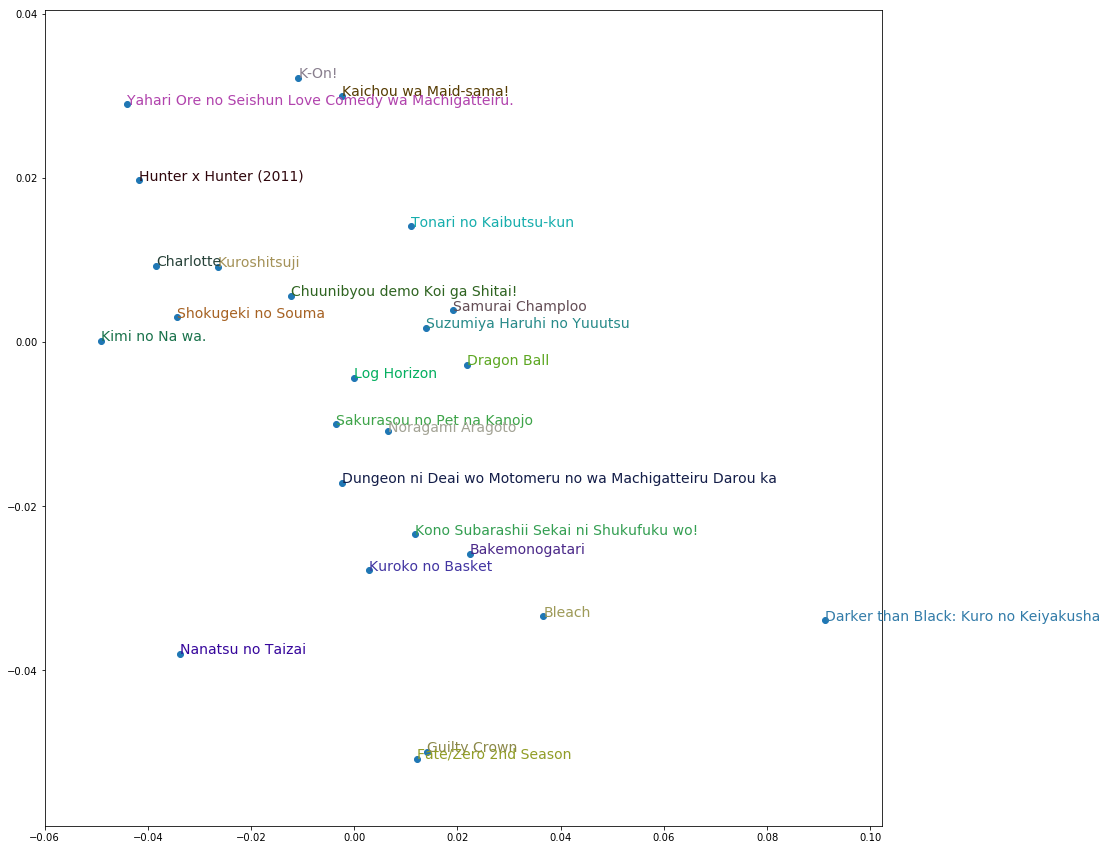

In [213]:
%matplotlib inline
import matplotlib.pyplot as plt
for comp in range(15):
    fac1= anime_pca[comp]
    fac2= anime_pca[comp+1]
    #anime_comp = [(f, anime_names[animes[animeid2idx[i]]]) for f,i in zip(fac, topAnime)]
    start=50; end=75
    X = fac1[start:end]
    Y = fac2[start:end]
    plt.figure(figsize=(15,15))
    plt.scatter(X, Y)
    for i, x, y in zip(topAnime[start:end], X, Y):
        plt.text(x,y,anime_names[animes[animeid2idx[i]]], color=np.random.rand(3)*0.7, fontsize=14)
    plt.show()
    #plt.plot()
    #print('component'+str(comp)+' top')
    #print('\n')
    #print(sorted(anime_comp, reverse=True)[:10])
    #print('\n')
    #print('component'+str(comp)+' bottom')
    #print('\n')
    #print(sorted(anime_comp)[:10])
    print('\n')

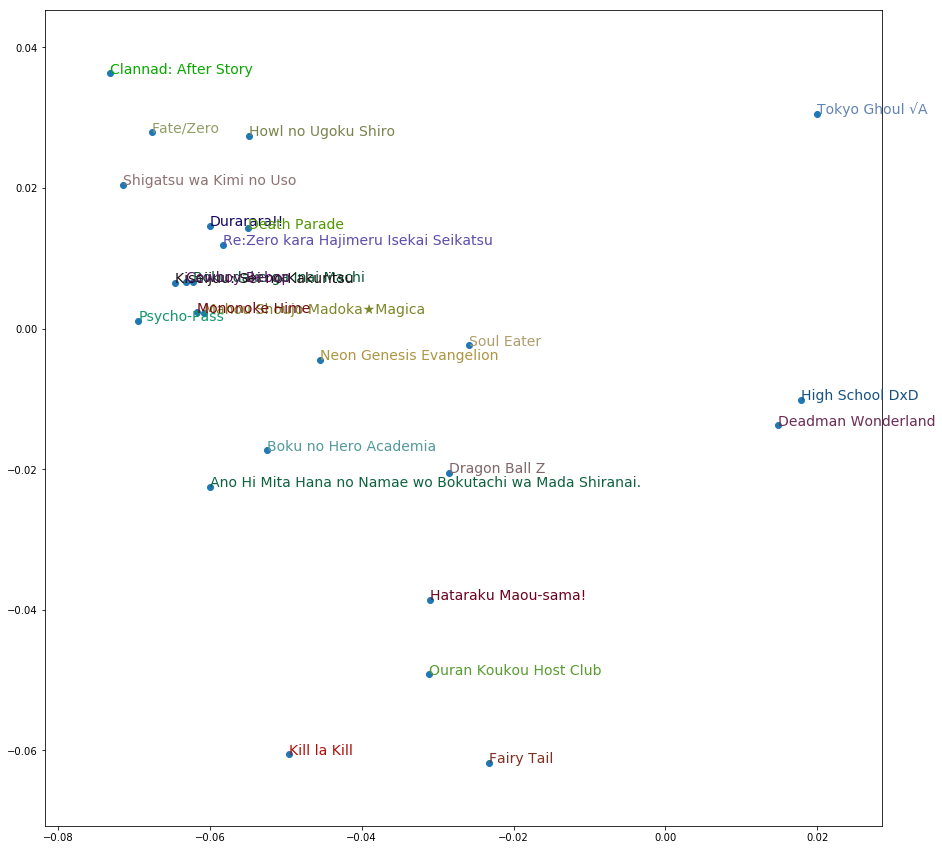

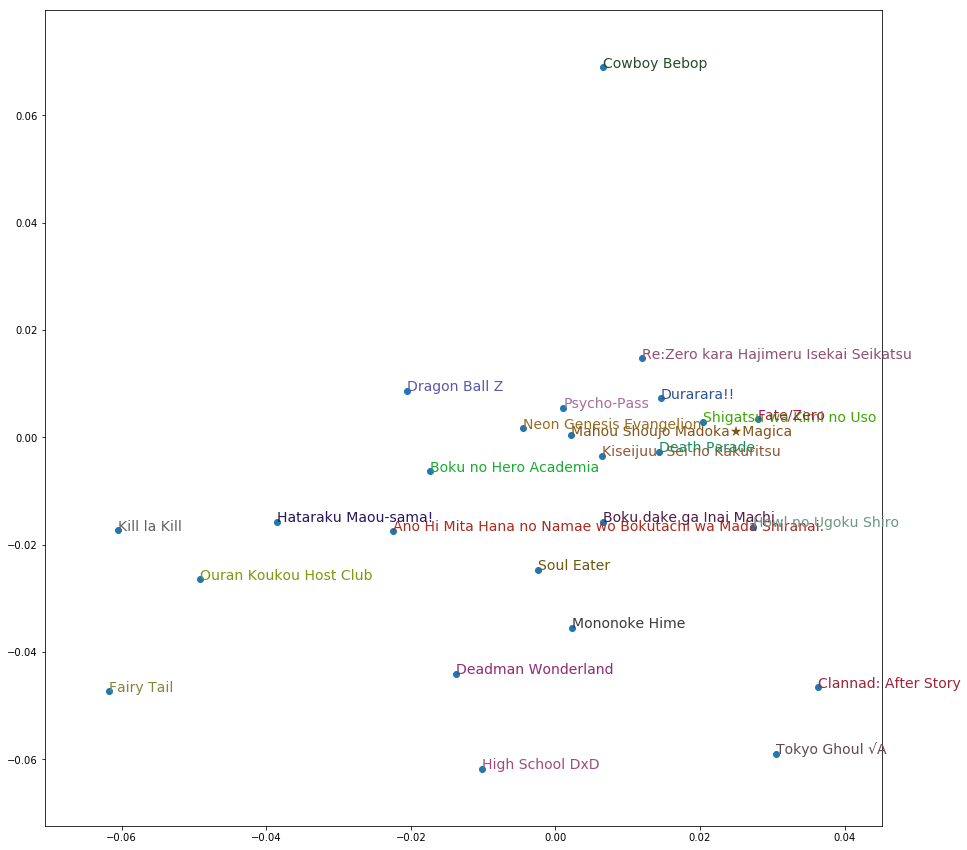

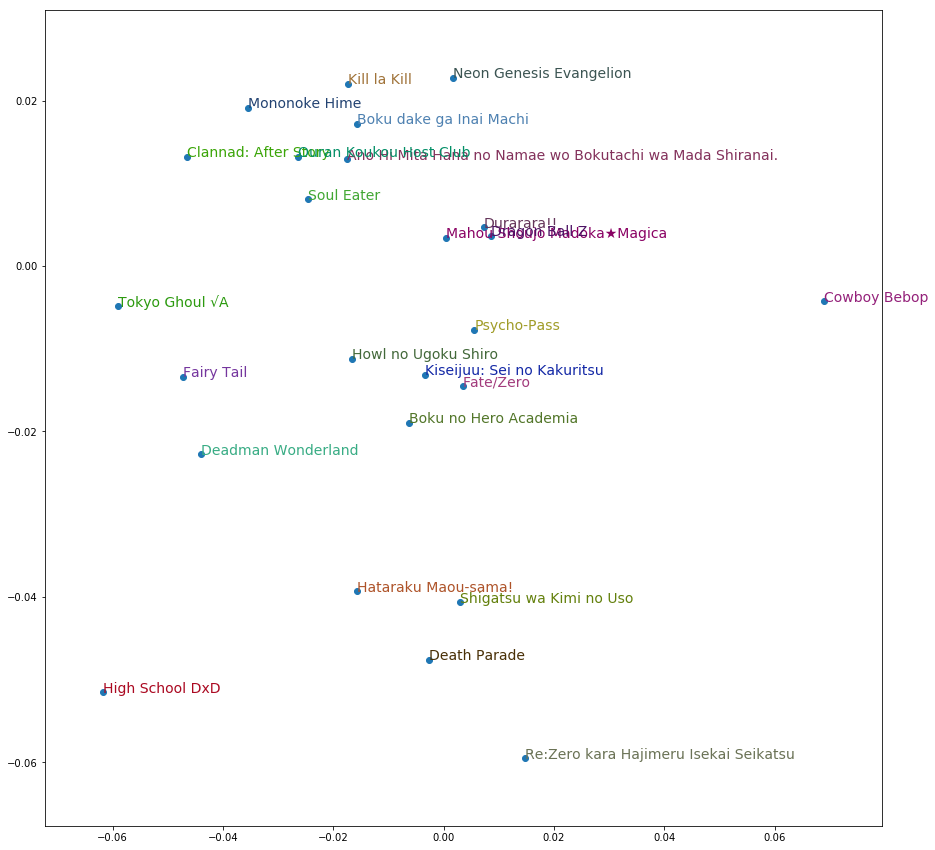

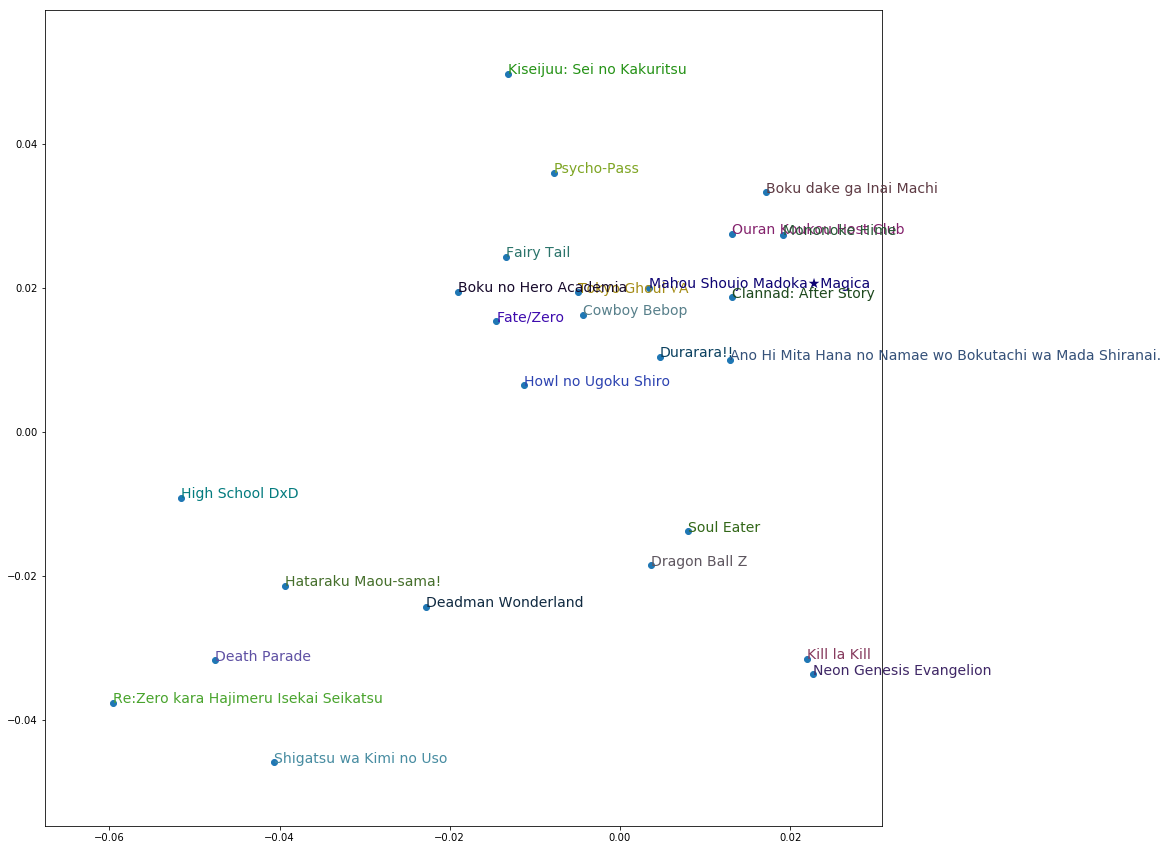

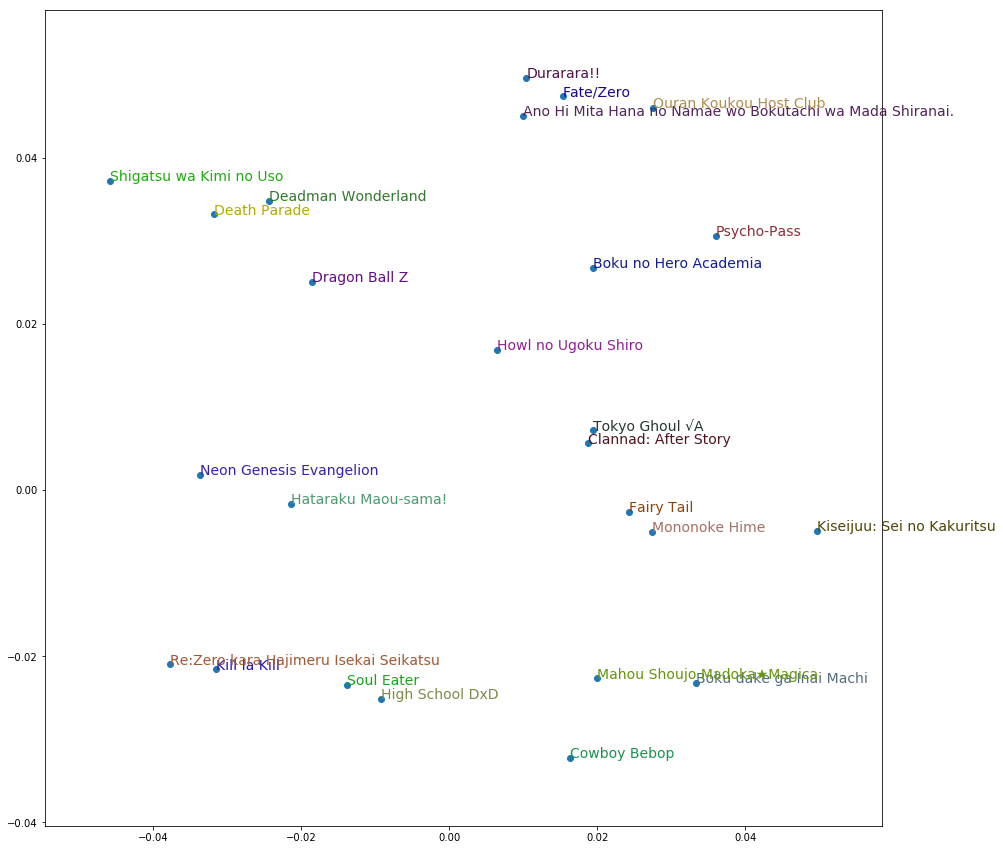

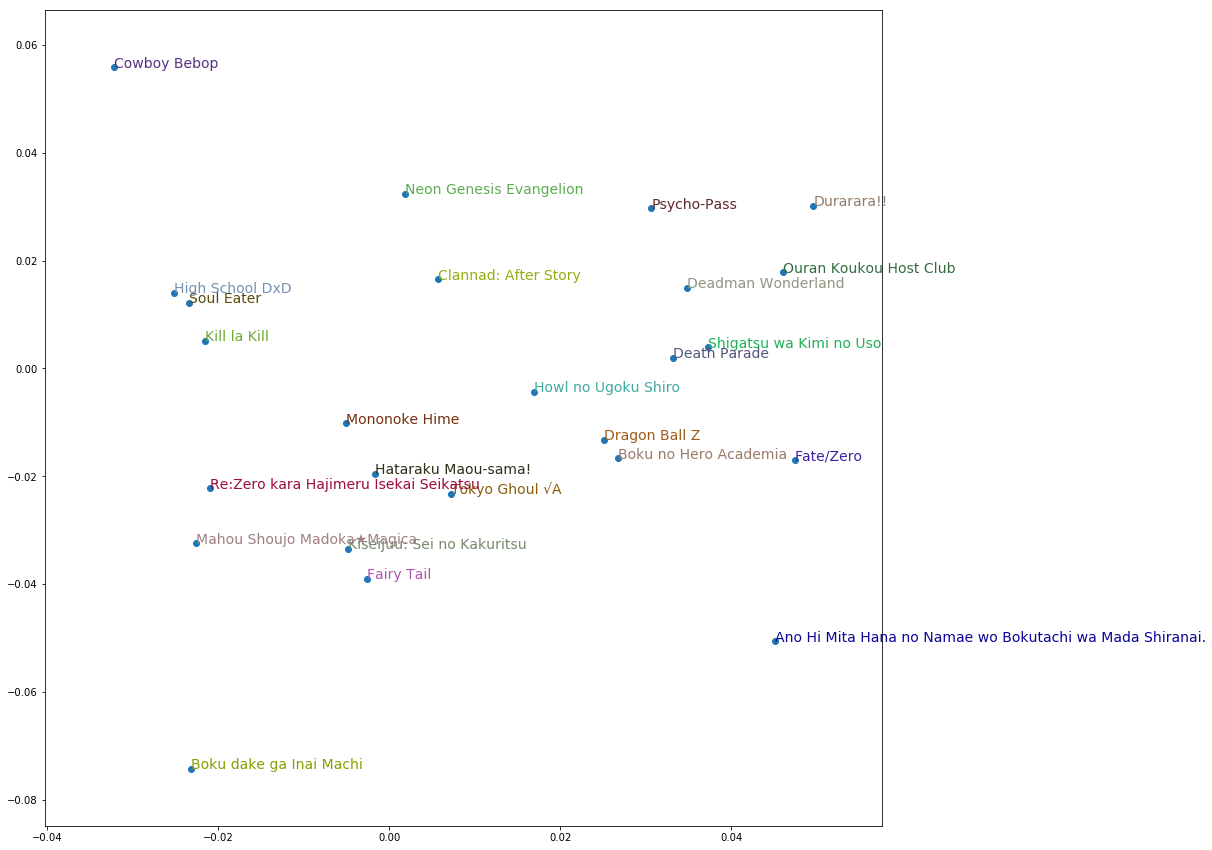

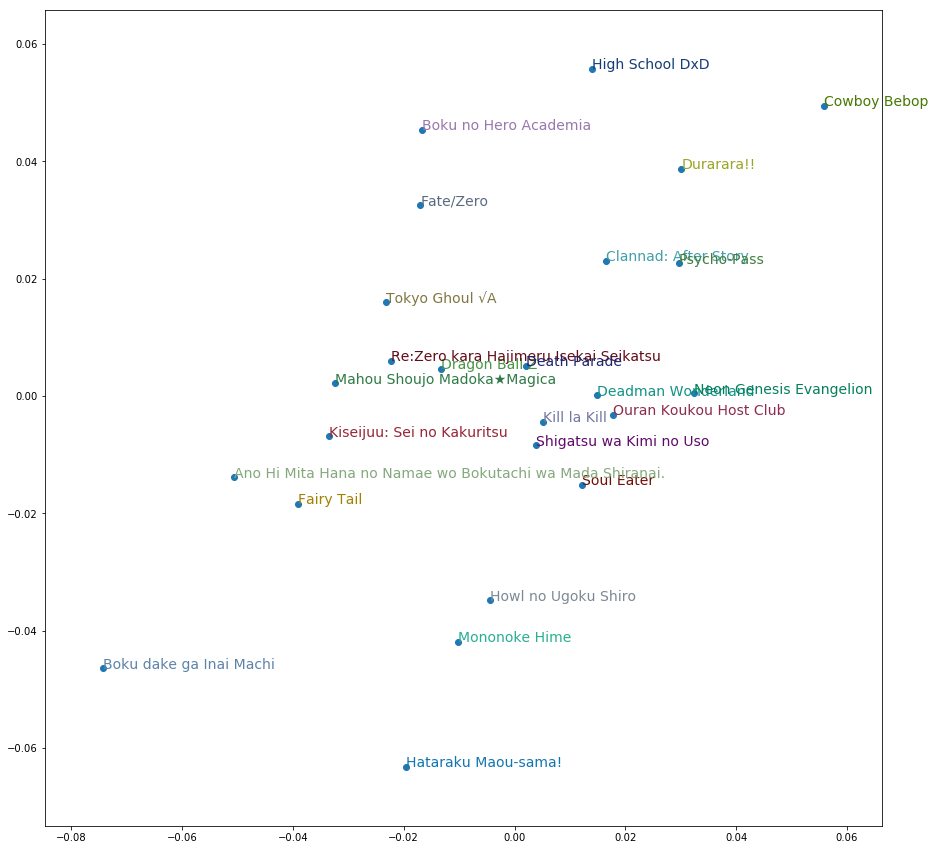

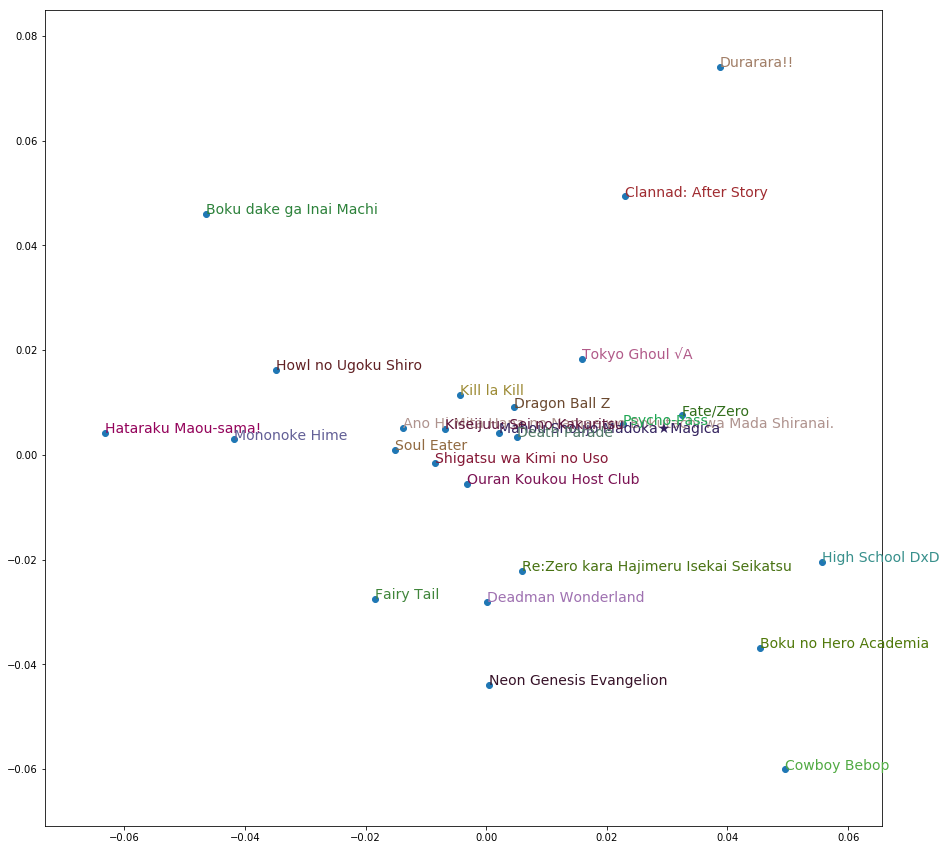

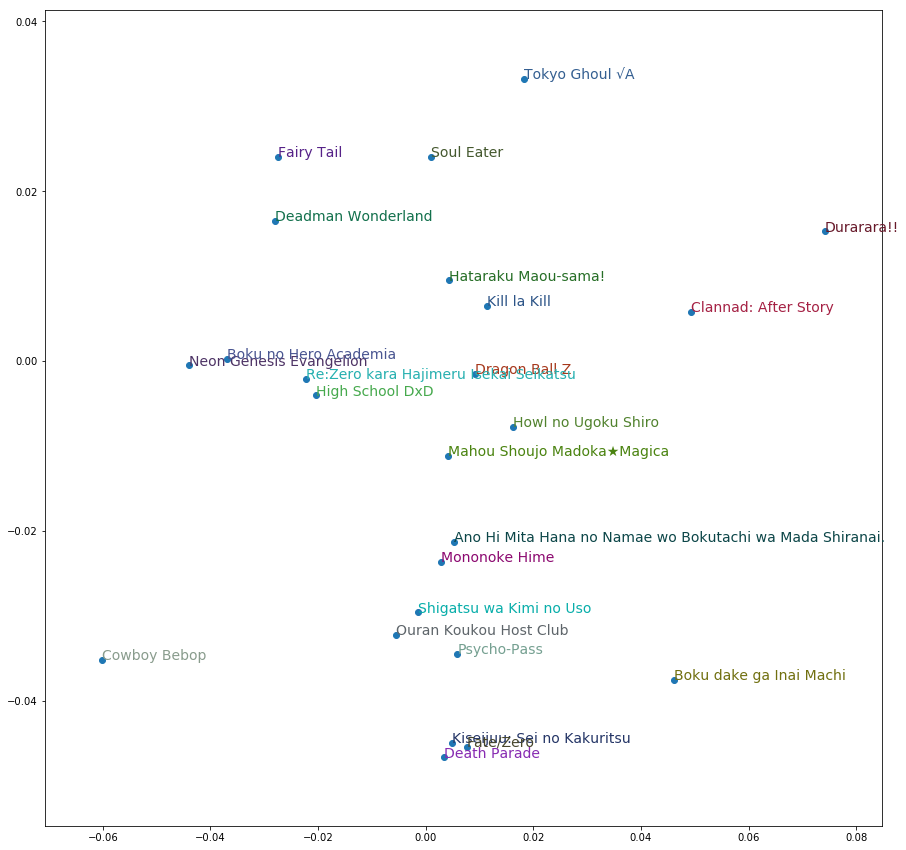

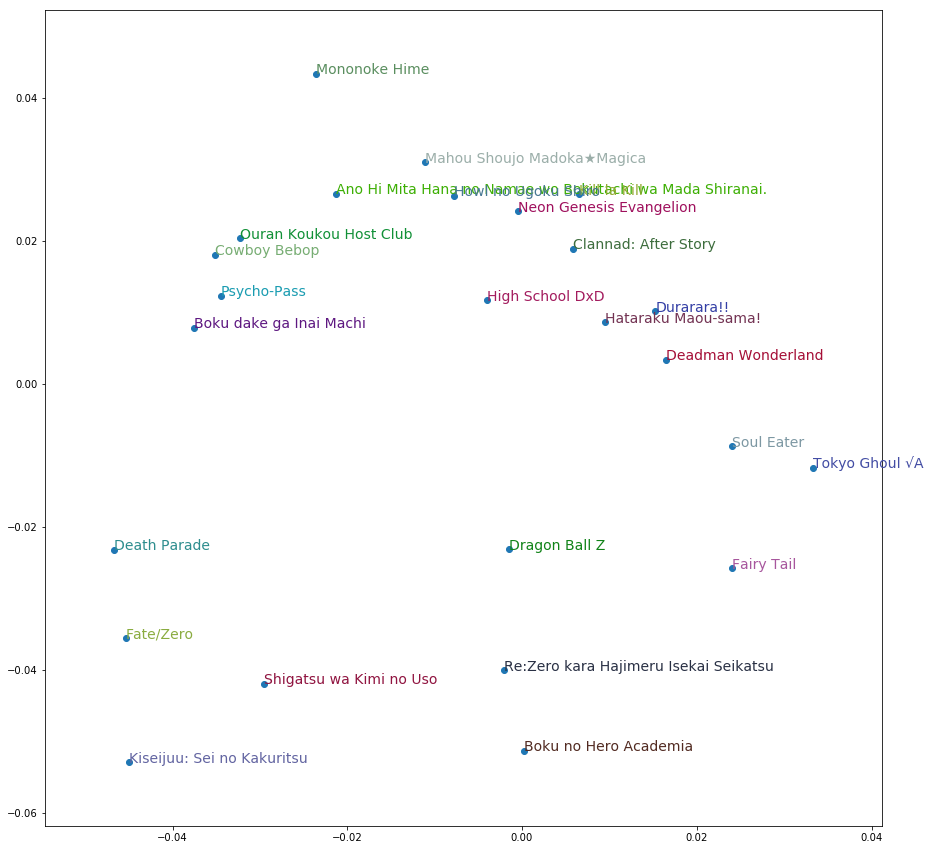

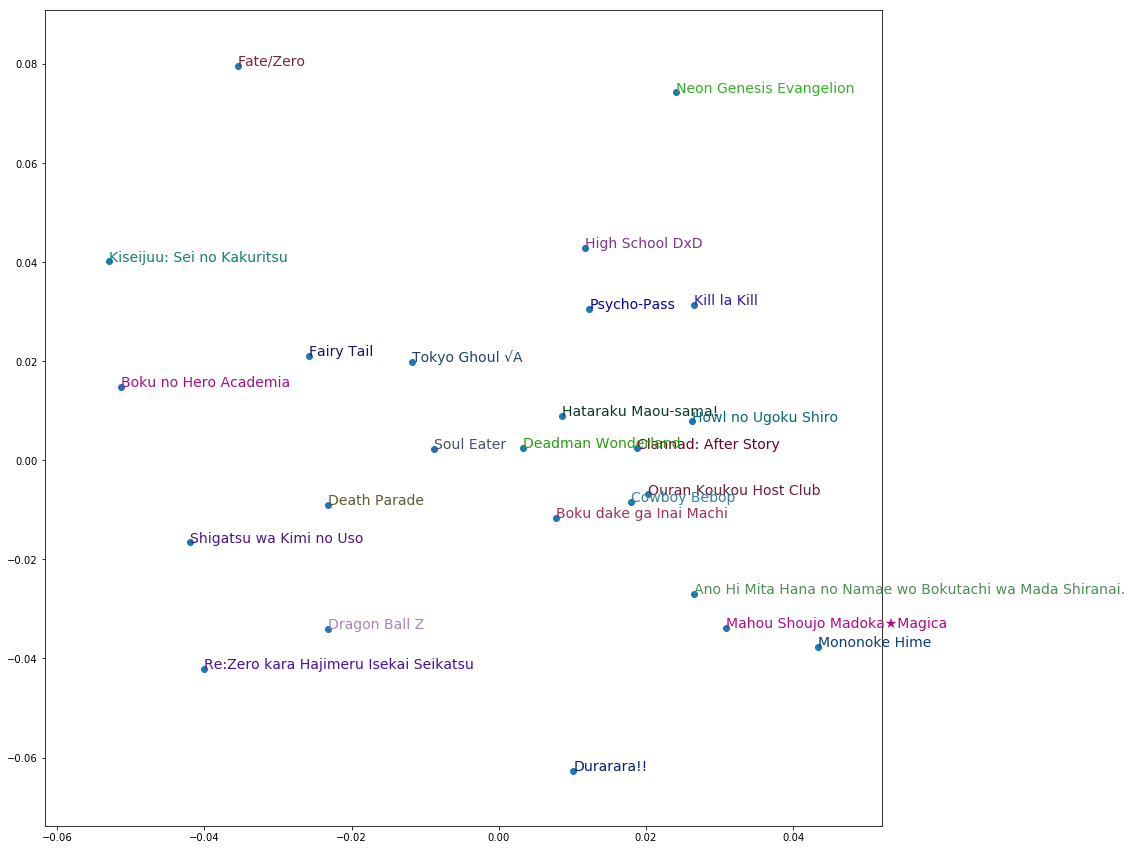

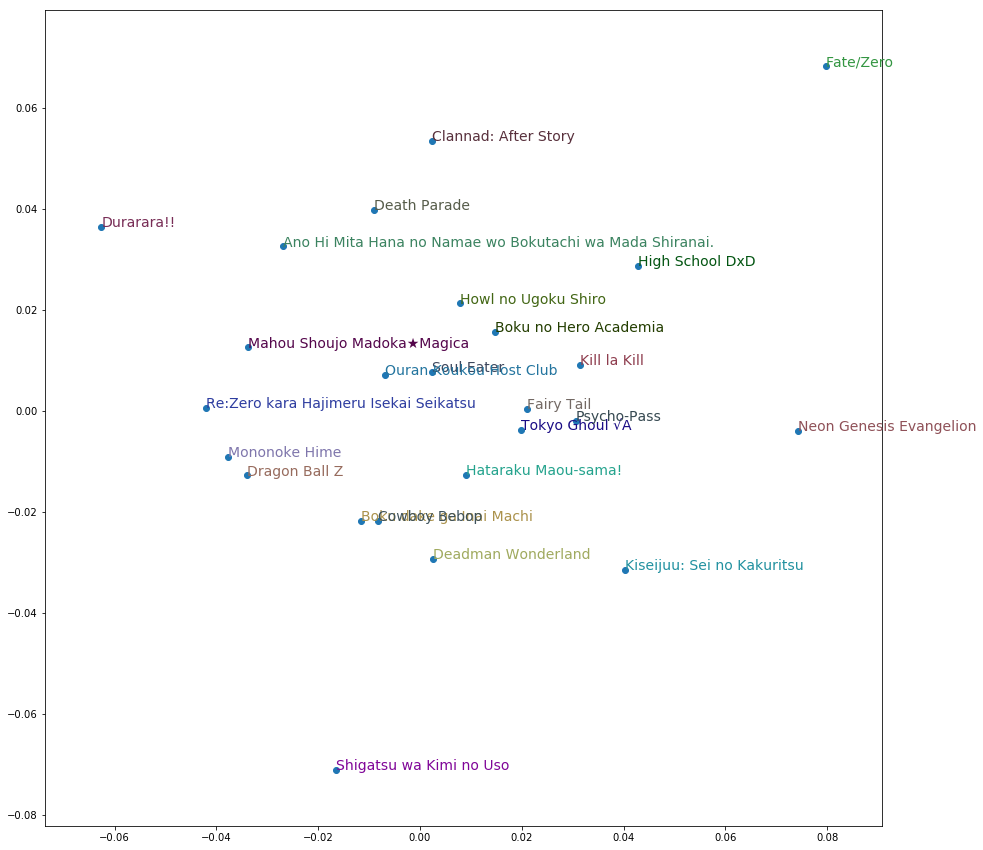

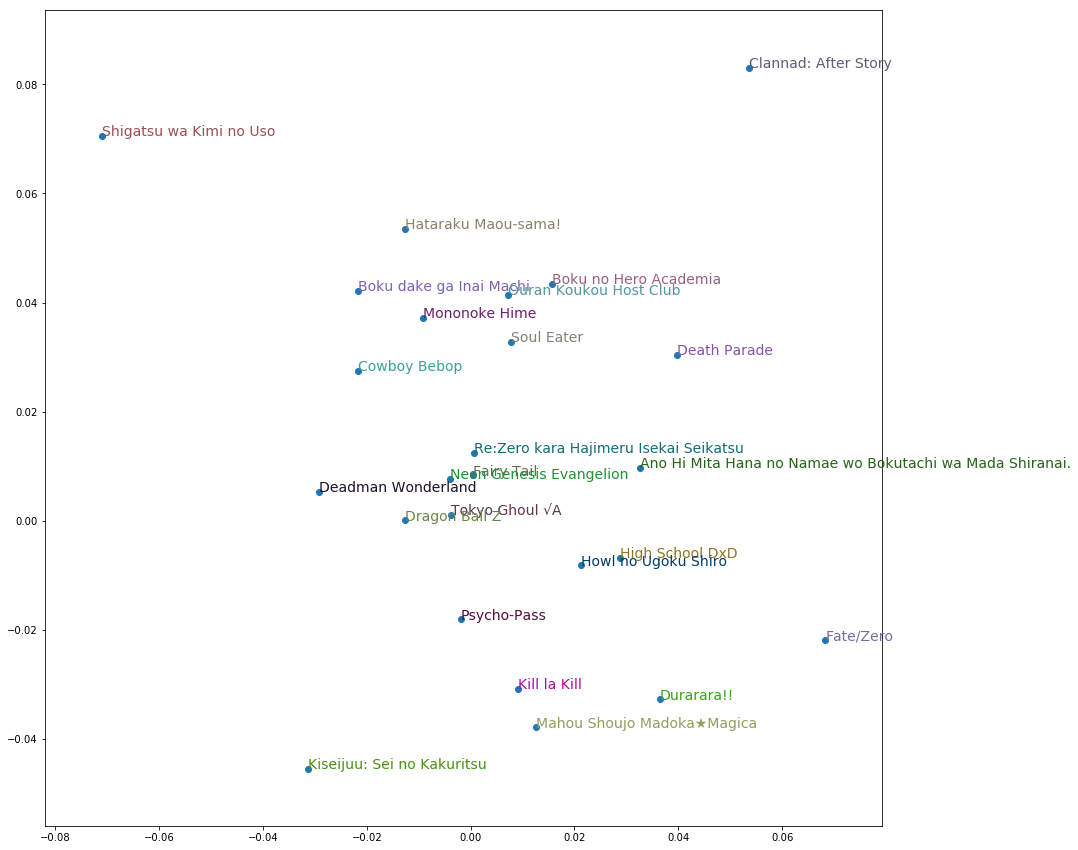

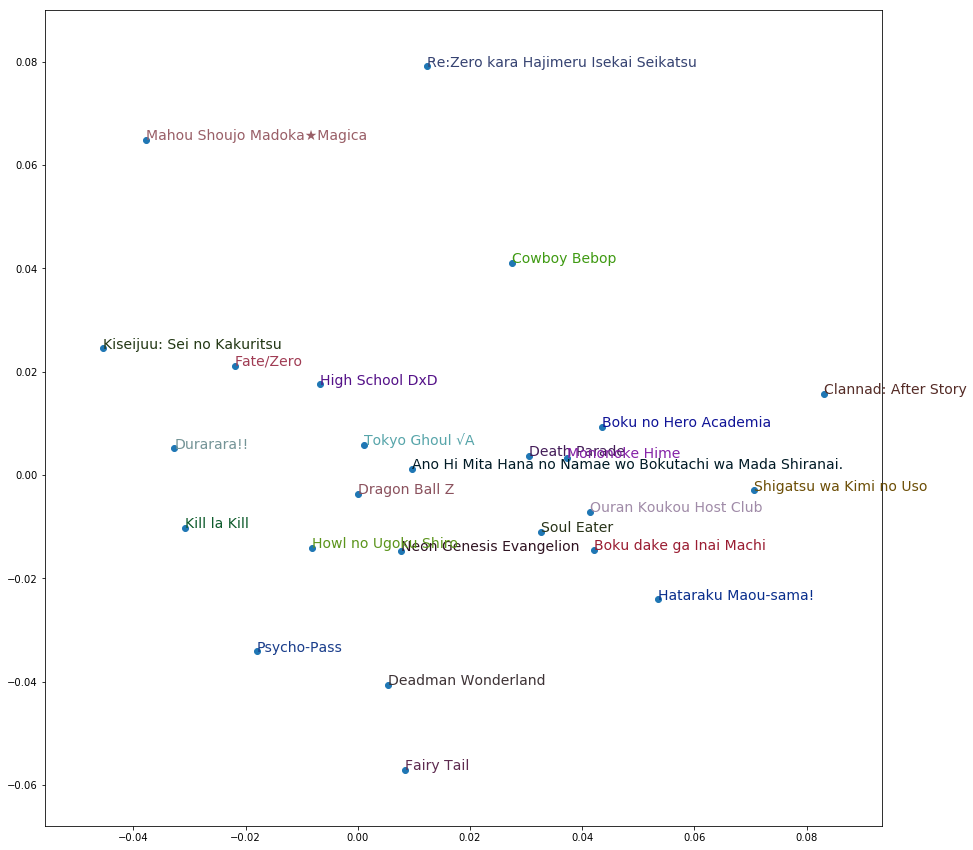

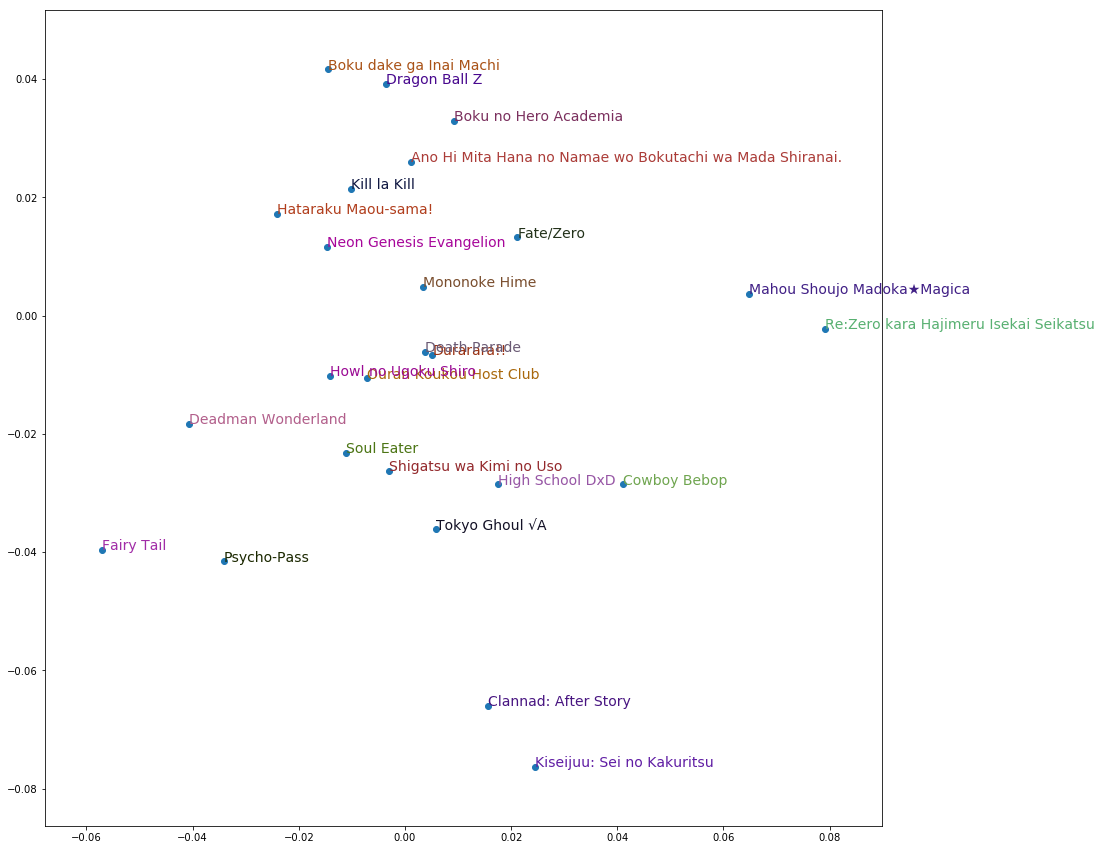

In [214]:
%matplotlib inline
import matplotlib.pyplot as plt
for comp in range(15):
    fac1= anime_pca[comp]
    fac2= anime_pca[comp+1]
    #anime_comp = [(f, anime_names[animes[animeid2idx[i]]]) for f,i in zip(fac, topAnime)]
    start=25; end=50
    X = fac1[start:end]
    Y = fac2[start:end]
    plt.figure(figsize=(15,15))
    plt.scatter(X, Y)
    for i, x, y in zip(topAnime[start:end], X, Y):
        plt.text(x,y,anime_names[animes[animeid2idx[i]]], color=np.random.rand(3)*0.7, fontsize=14)
    plt.show()
    #plt.plot()
    #print('component'+str(comp)+' top')
    #print('\n')
    #print(sorted(anime_comp, reverse=True)[:10])
    #print('\n')
    #print('component'+str(comp)+' bottom')
    #print('\n')
    #print(sorted(anime_comp)[:10])
    print('\n')

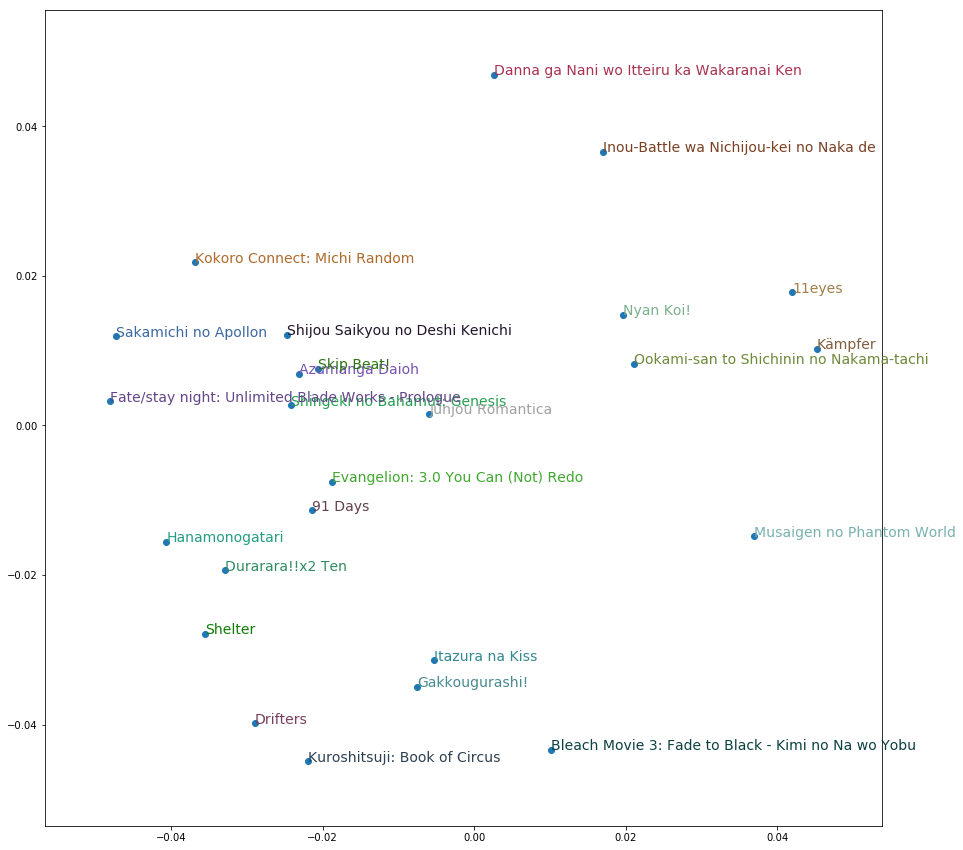

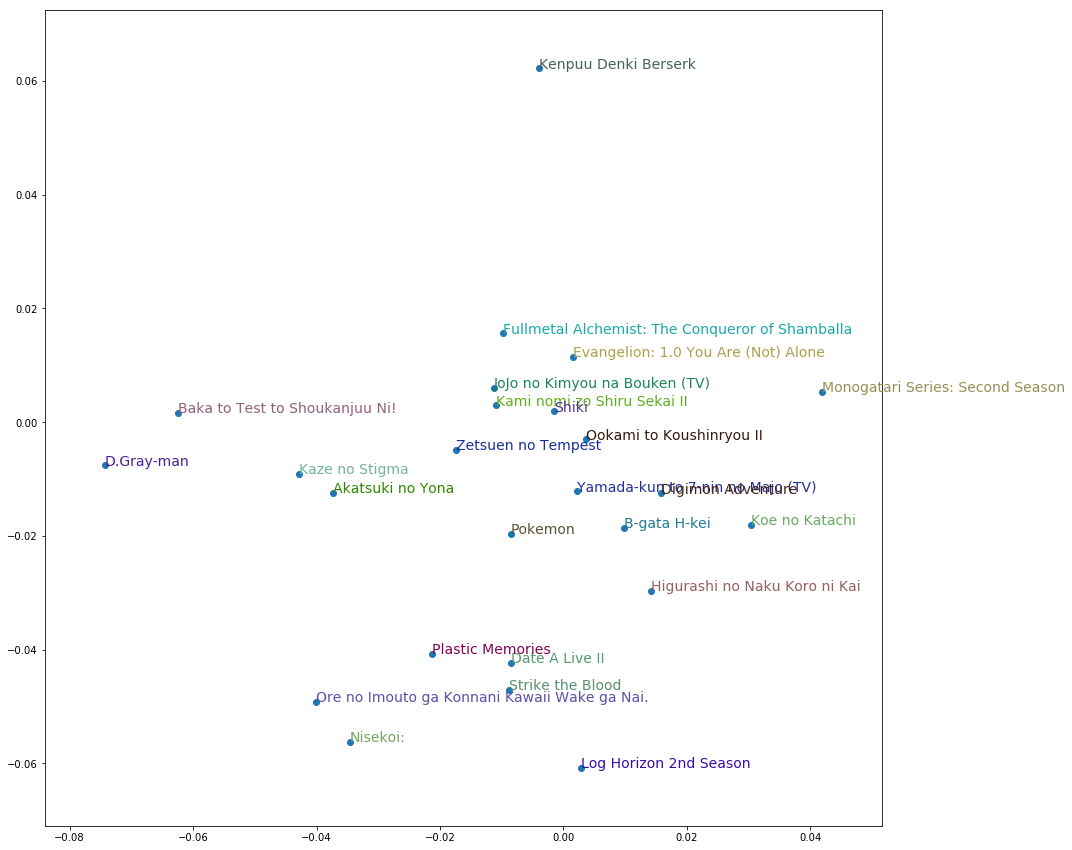

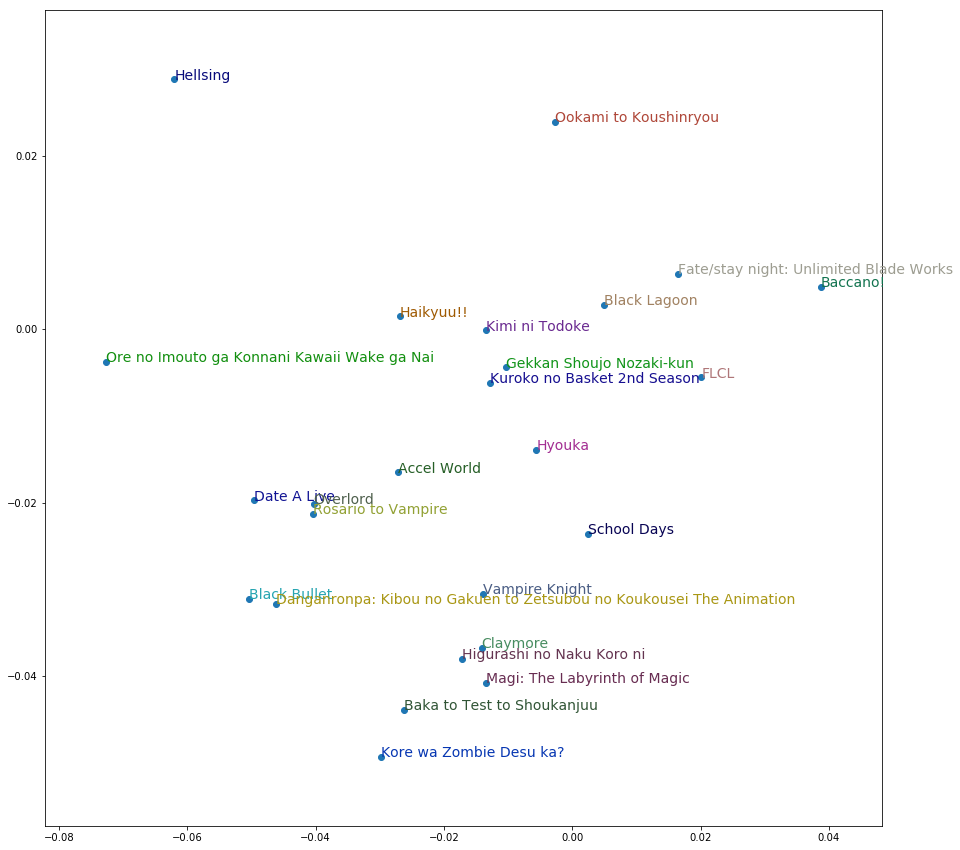

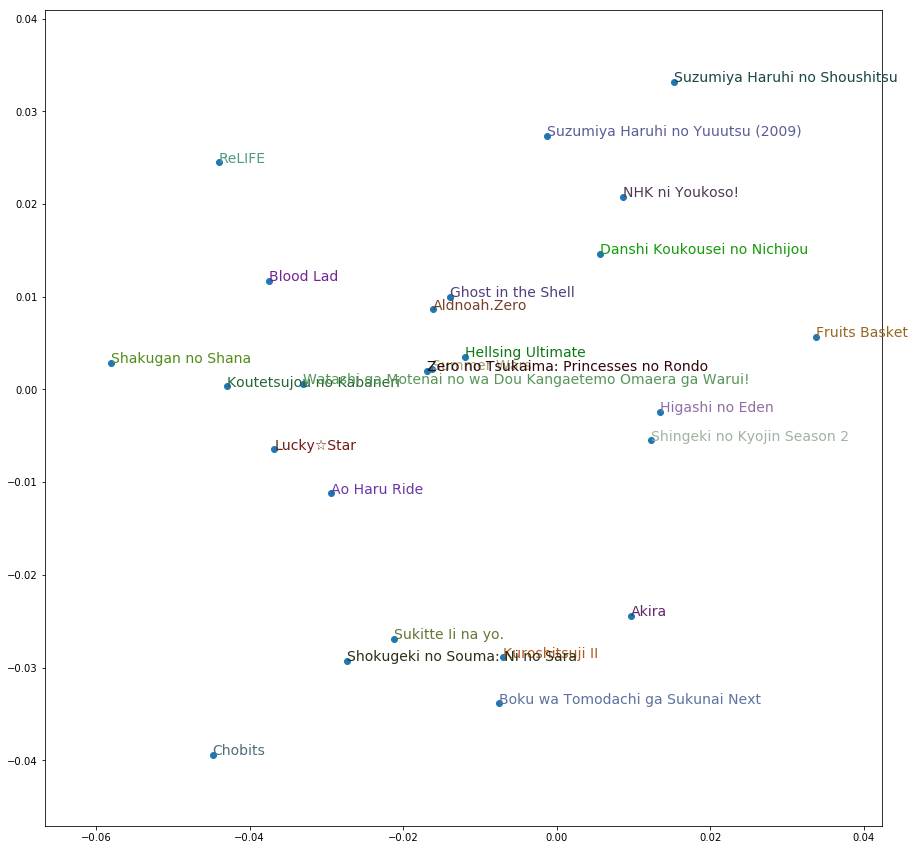

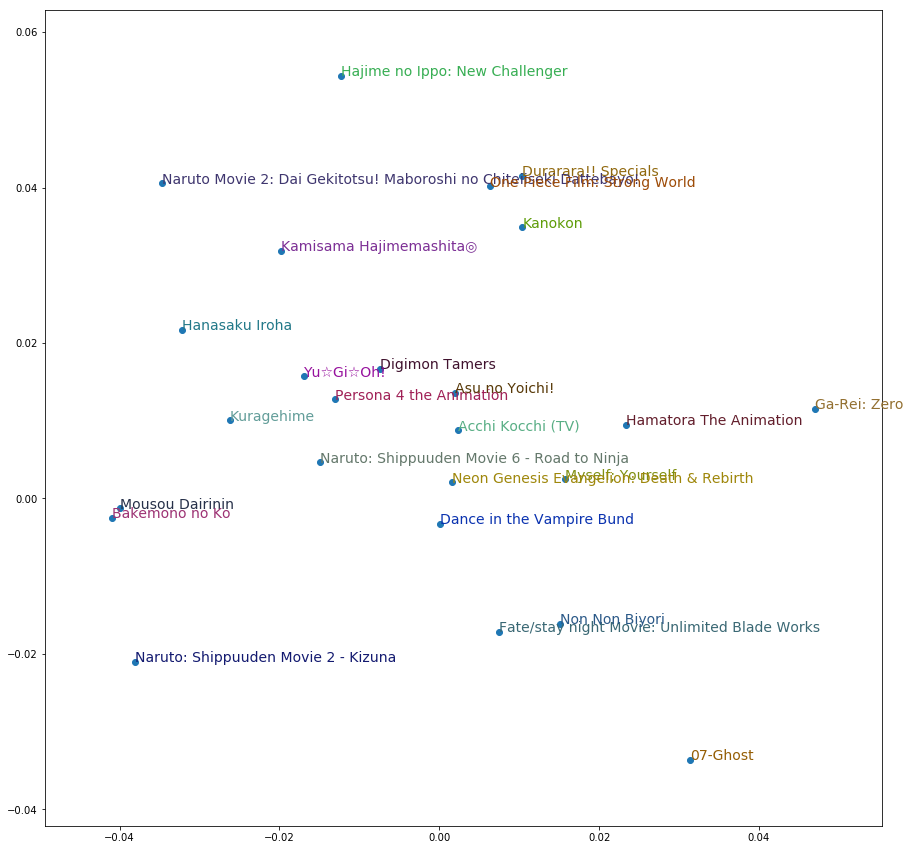

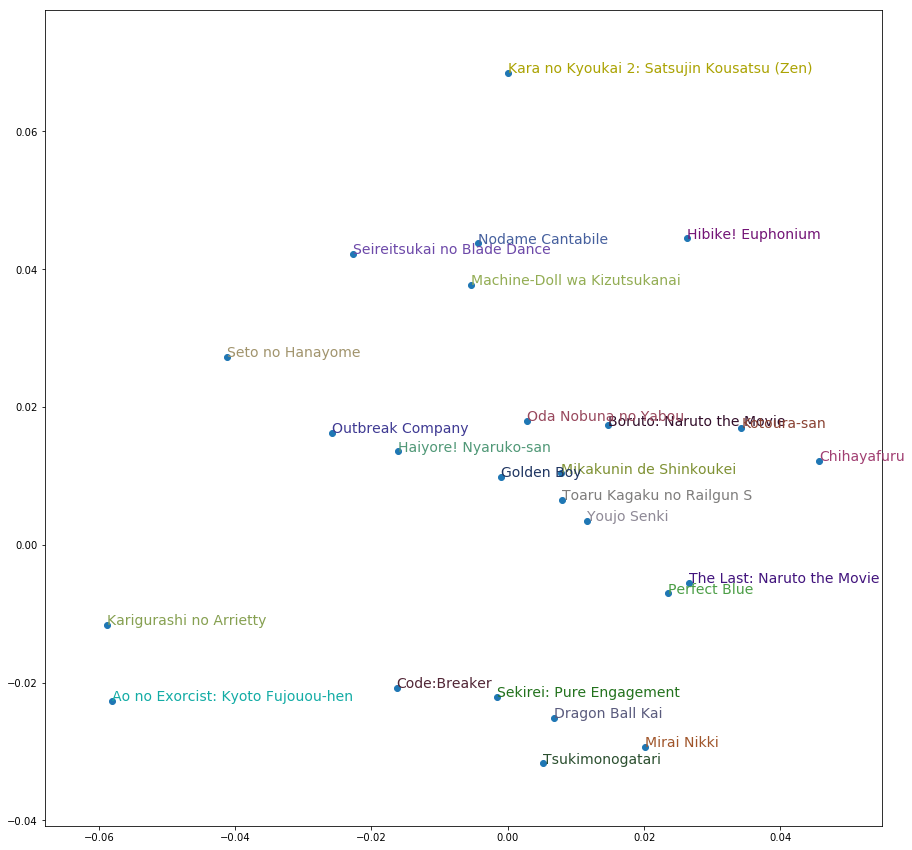

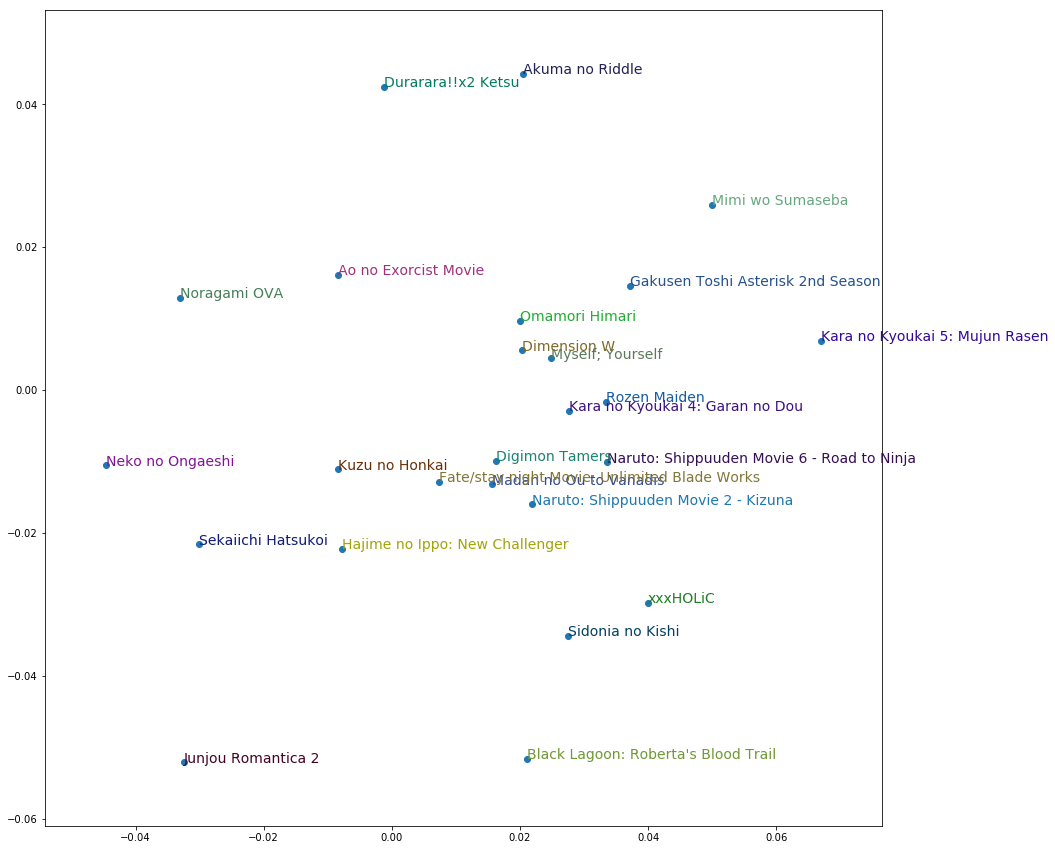

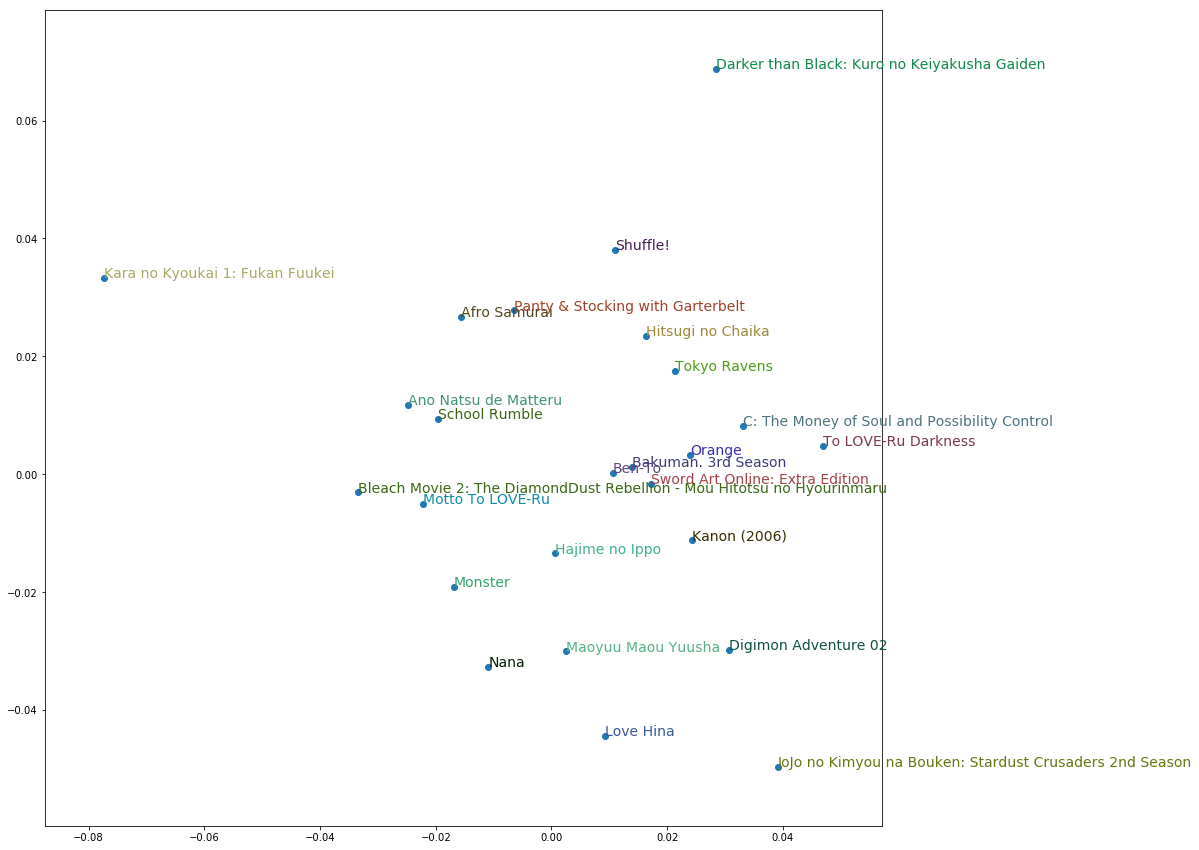

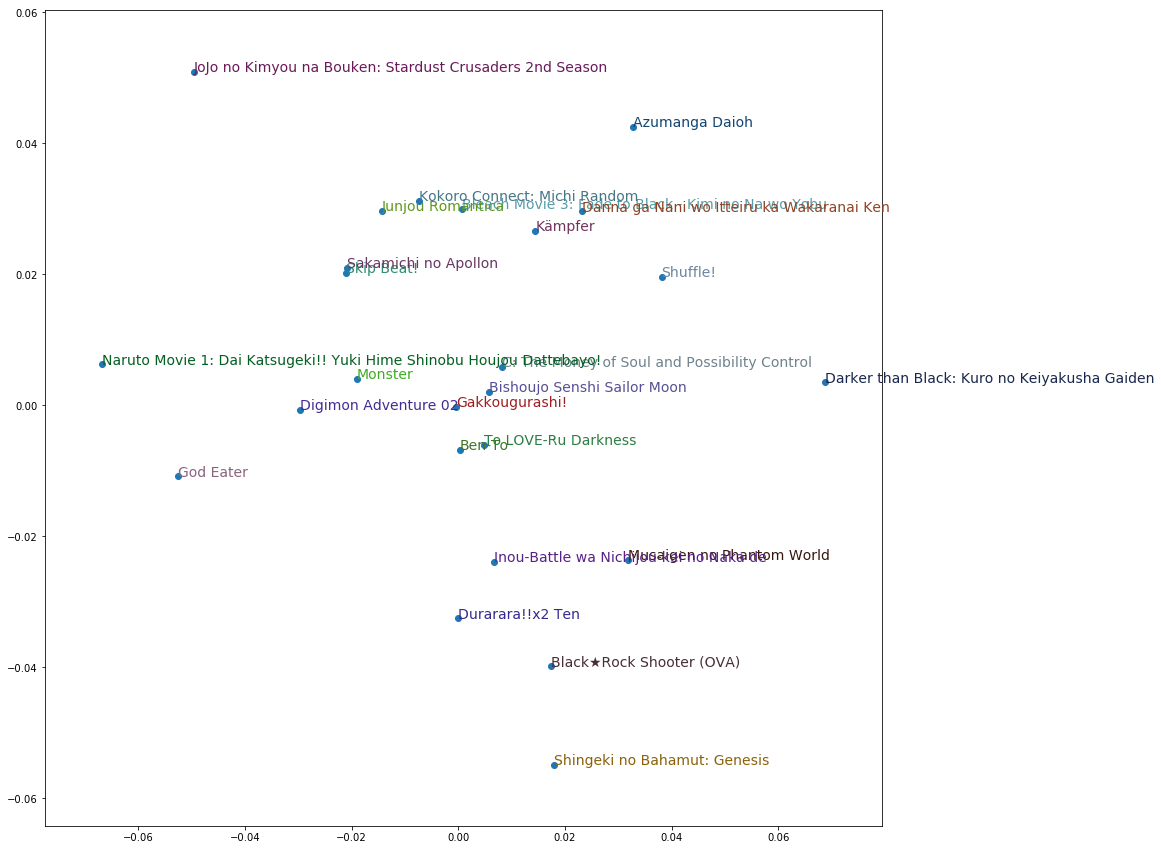

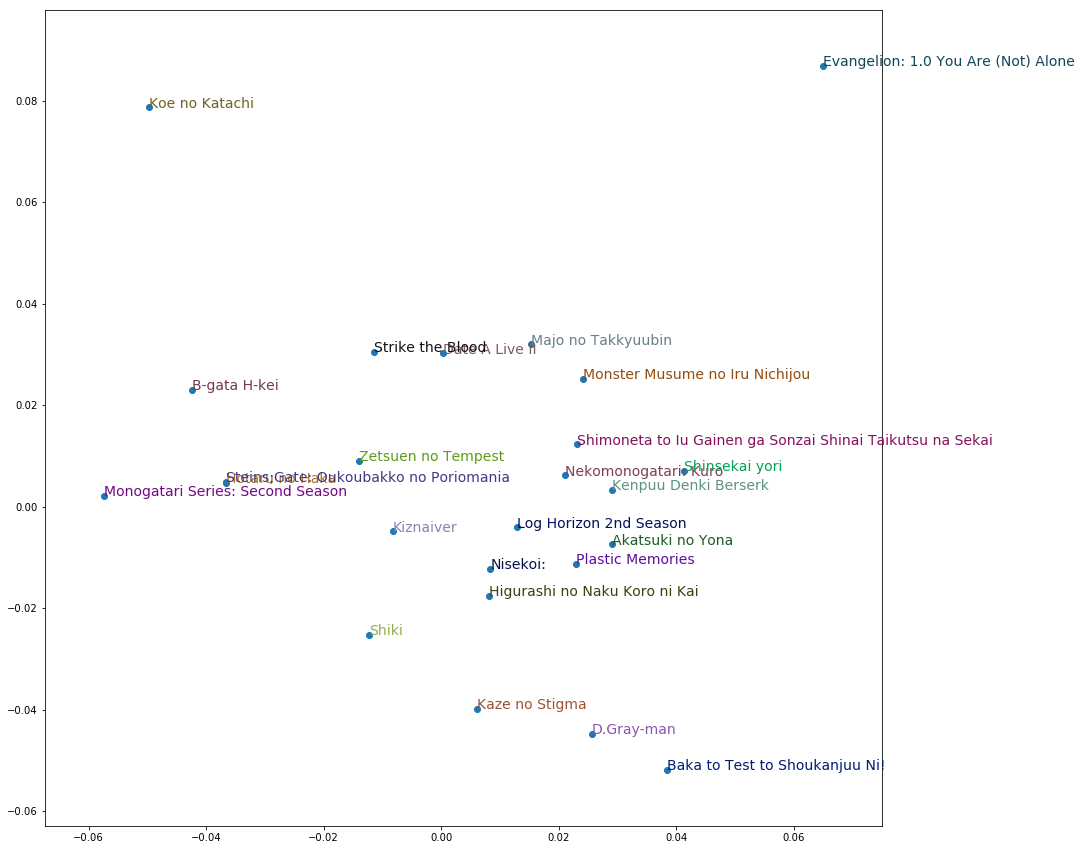

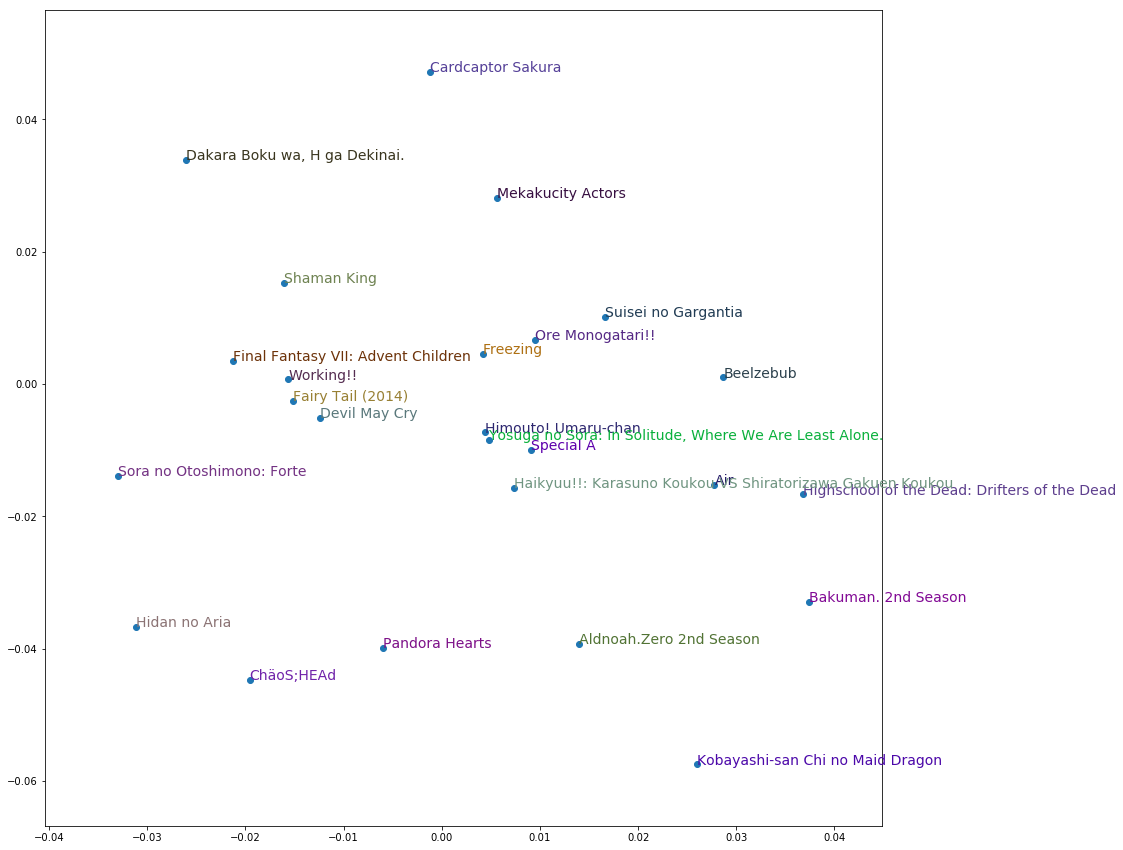

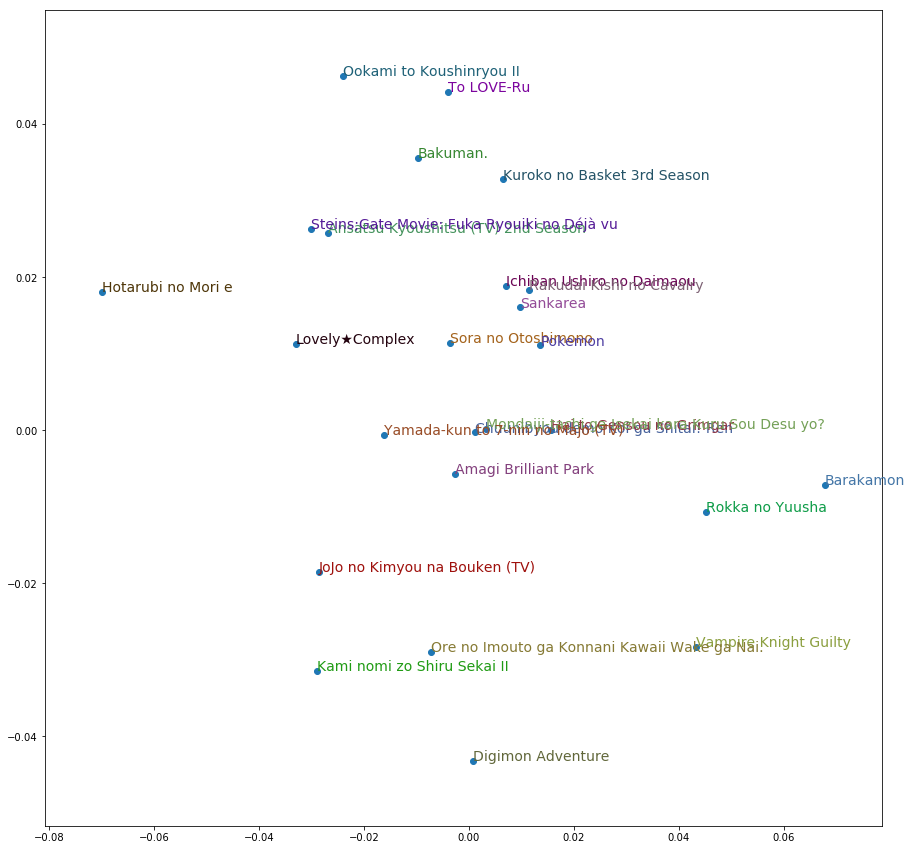

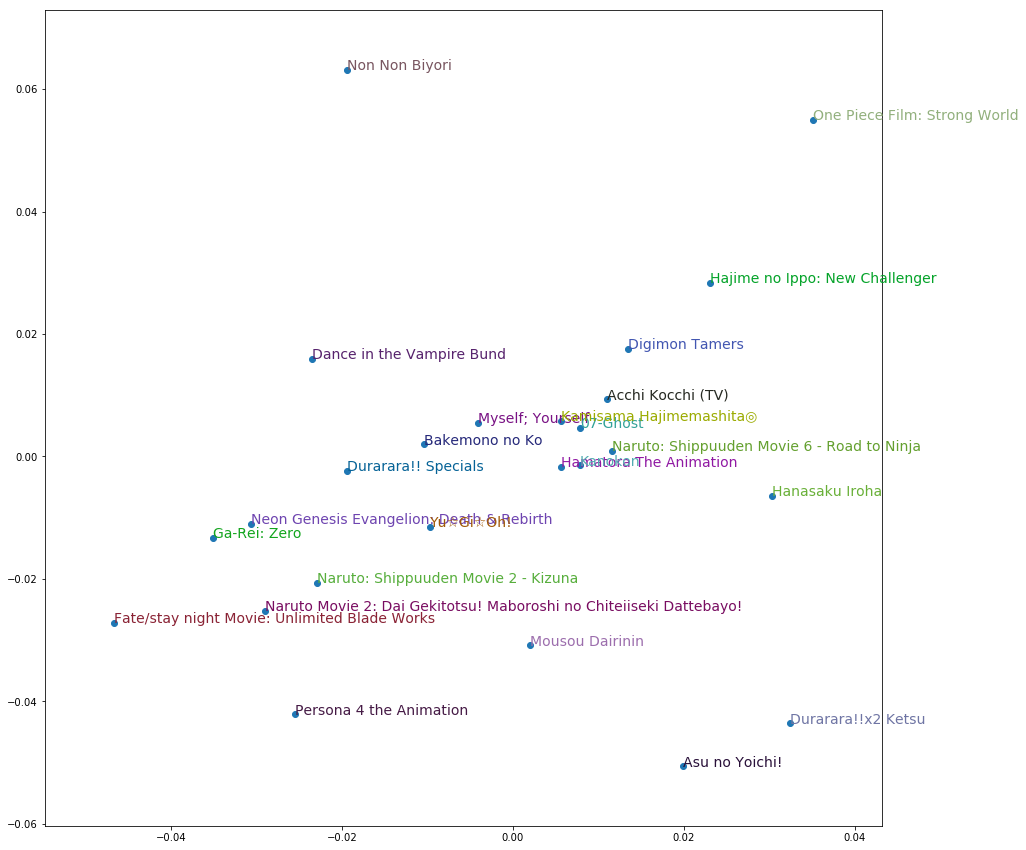

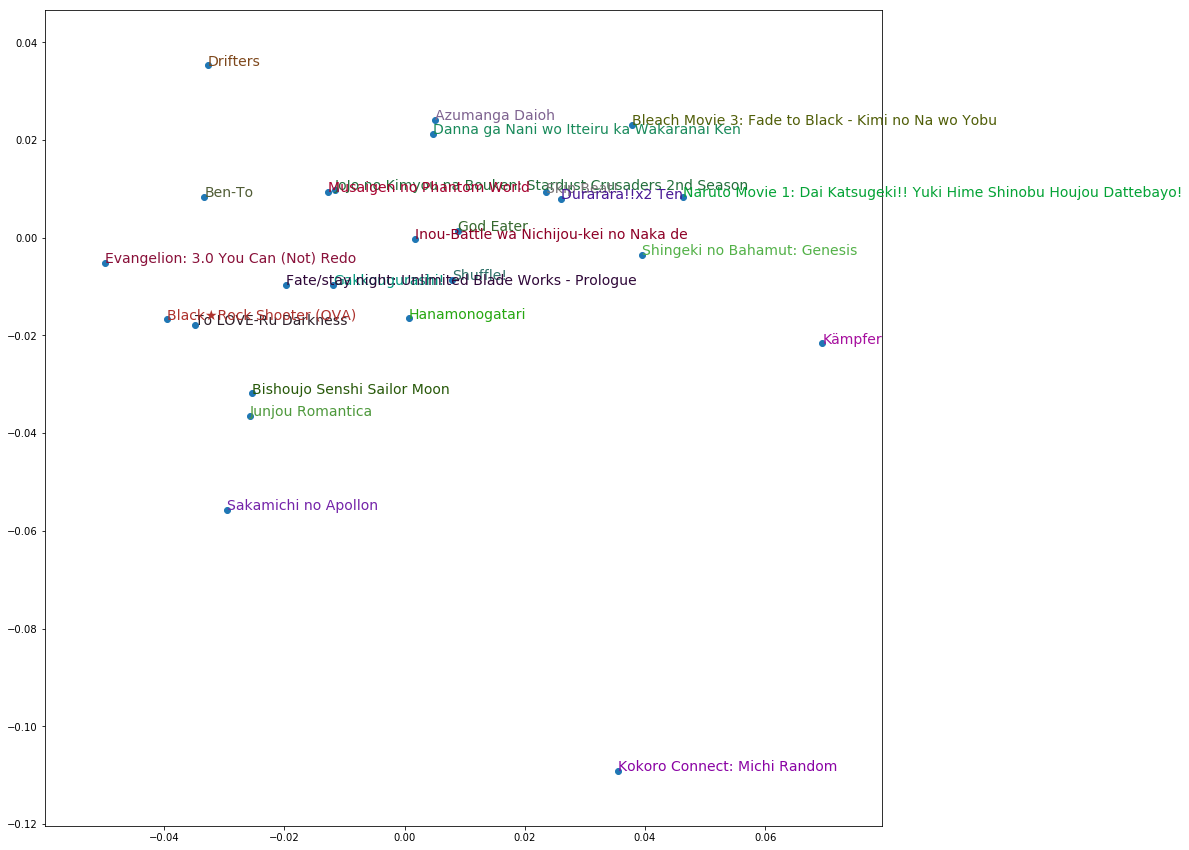

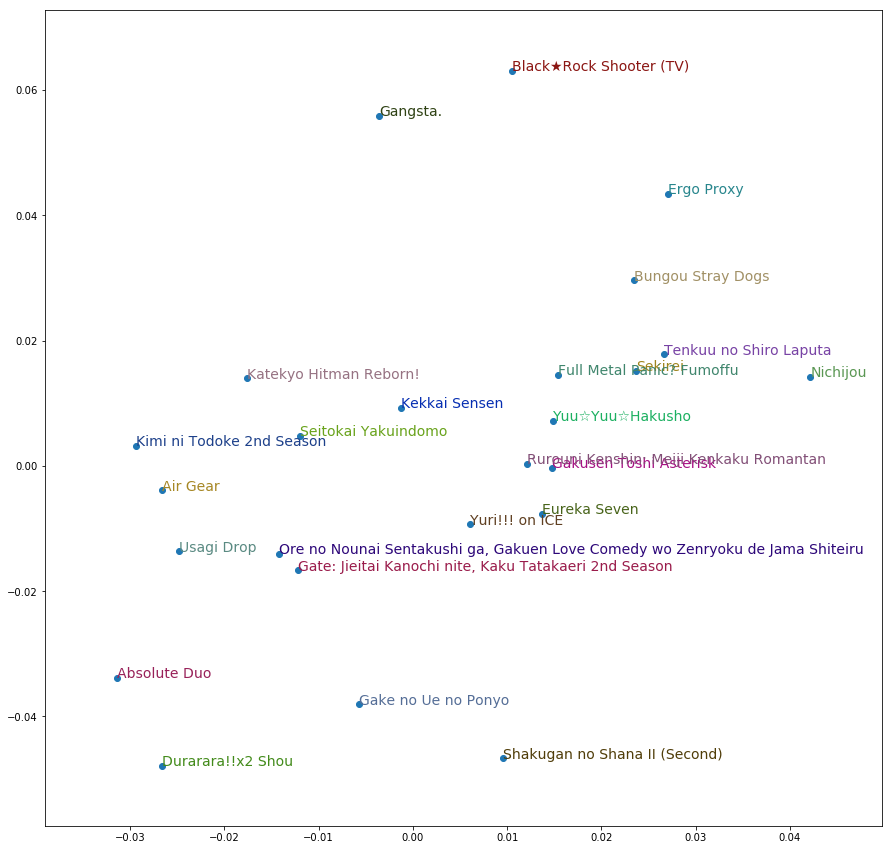

In [215]:
%matplotlib inline
import matplotlib.pyplot as plt
for comp in range(15):
    fac1= anime_pca[comp]
    fac2= anime_pca[comp+1]
    #anime_comp = [(f, anime_names[animes[animeid2idx[i]]]) for f,i in zip(fac, topAnime)]
    
    start=np.random.randint(475) 
    end= start+25
    X = fac1[start:end]
    Y = fac2[start:end]
    plt.figure(figsize=(15,15))
    plt.scatter(X, Y)
    for i, x, y in zip(topAnime[start:end], X, Y):
        plt.text(x,y,anime_names[animes[animeid2idx[i]]], color=np.random.rand(3)*0.7, fontsize=14)
    plt.show()
    #plt.plot()
    #print('component'+str(comp)+' top')
    #print('\n')
    #print(sorted(anime_comp, reverse=True)[:10])
    #print('\n')
    #print('component'+str(comp)+' bottom')
    #print('\n')
    #print(sorted(anime_comp)[:10])
    print('\n')

Now we can look the raw weights, rather than the pca:


In [216]:
anime_weights = anime_emb

In [217]:
pca2 = PCA(n_components=18)
anime_pca = pca.fit_transform(anime_emb)

In [218]:
len(anime_pca)

1750

In [219]:
from sklearn.preprocessing import StandardScaler

In [220]:
ss= StandardScaler()

In [221]:
scaledweights= ss.fit_transform(anime_weights)

In [222]:
from sklearn.cluster import KMeans
from sklearn.cluster import AgglomerativeClustering
from sklearn.cluster import DBSCAN

In [223]:
kmc= AgglomerativeClustering(n_clusters=12, affinity='cosine', linkage='average')
#kmc = KMeans(n_clusters=18)
# explaining the choices here: cosine means we're looking for cosimiliarity, average linkage helps with our intention of finding generic
# anime genres. 

In [224]:
kmc.fit(scaledweights)# This step can take a very very long time. 

AgglomerativeClustering(affinity='cosine', compute_full_tree='auto',
            connectivity=None, linkage='average',
            memory=Memory(cachedir=None), n_clusters=12,
            pooling_func=<function mean at 0x7fb3b9284f28>)

In [225]:
klabels= kmc.labels_

In [226]:
klabels

array([0, 0, 1, ..., 1, 0, 1])

In [227]:
animu_cluster =pd.read_csv('animeinfo3.csv')

In [228]:
animu_cluster['kmeanscluster']='na'

In [229]:
for animeclusternum in range(len(topAnime)):
    animenum = animes[animeid2idx[topAnime[animeclusternum]]]
    print(klabels[animeclusternum])
    print(anime_names[animes[animeid2idx[topAnime[animeclusternum]]]])
    animu_cluster.loc[(animu_cluster['animeid']==animenum),['kmeanscluster']]=klabels[animeclusternum]

0
Death Note
0
Shingeki no Kyojin
1
Sword Art Online
0
Fullmetal Alchemist: Brotherhood
0
Angel Beats!
0
Code Geass: Hangyaku no Lelouch
0
Tokyo Ghoul
1
Naruto
0
One Punch Man
0
No Game No Life
0
Mirai Nikki (TV)
0
Toradora!
0
Code Geass: Hangyaku no Lelouch R2
0
Steins;Gate
2
Elfen Lied
1
Ao no Exorcist
0
Fullmetal Alchemist
0
Sen to Chihiro no Kamikakushi
1
Highschool of the Dead
1
Sword Art Online II
0
Noragami
0
Another
0
Tengen Toppa Gurren Lagann
0
Akame ga Kill!
0
Clannad
0
Soul Eater
1
Tokyo Ghoul √A
0
Ano Hi Mita Hana no Namae wo Bokutachi wa Mada Shiranai.
0
Boku dake ga Inai Machi
0
Mahou Shoujo Madoka★Magica
0
Kill la Kill
0
Clannad: After Story
0
Kiseijuu: Sei no Kakuritsu
0
Hataraku Maou-sama!
1
Deadman Wonderland
0
Durarara!!
0
Psycho-Pass
0
Ouran Koukou Host Club
0
Dragon Ball Z
1
High School DxD
0
Shigatsu wa Kimi no Uso
0
Fate/Zero
0
Neon Genesis Evangelion
0
Cowboy Bebop
0
Howl no Ugoku Shiro
0
Re:Zero kara Hajimeru Isekai Seikatsu
0
Boku no Hero Academia
0
Death Par

1
Hetalia Axis Powers
0
Sayonara Zetsubou Sensei
1
Denpa Onna to Seishun Otoko
0
Death Billiards
0
Phantom: Requiem for the Phantom
1
Bokusatsu Tenshi Dokuro-chan
0
Shakugan no Shana III (Final)
0
Neko no Ongaeshi
4
Ao no Exorcist Movie
1
Madan no Ou to Vanadis
1
Akuma no Riddle
1
Omamori Himari
0
Kara no Kyoukai 4: Garan no Dou
1
Dimension W
1
Gakusen Toshi Asterisk 2nd Season
0
Kara no Kyoukai 5: Mujun Rasen
0
Sekaiichi Hatsukoi
0
Noragami OVA
0
Kuzu no Honkai
0
xxxHOLiC
0
Sidonia no Kishi
0
Black Lagoon: Roberta's Blood Trail
0
Mimi wo Sumaseba
1
Rozen Maiden
0
Junjou Romantica 2
0
Durarara!!x2 Ketsu
1
Naruto: Shippuuden Movie 6 - Road to Ninja
1
Naruto: Shippuuden Movie 2 - Kizuna
1
Myself; Yourself
1
Digimon Tamers
1
Fate/stay night Movie: Unlimited Blade Works
0
Hajime no Ippo: New Challenger
0
Mousou Dairinin
0
Bakemono no Ko
1
07-Ghost
0
Hanasaku Iroha
0
Ga-Rei: Zero
1
Hamatora The Animation
0
Persona 4 the Animation
1
Acchi Kocchi (TV)
0
Durarara!! Specials
1
Asu no Yoichi!
1


1
Rail Wars!
1
Medaka Box Abnormal
0
xxxHOLiC Kei
0
Cardcaptor Sakura Movie 2: Fuuin Sareta Card
1
Rokujouma no Shinryakusha!? (TV)
1
Watashi ga Motete Dousunda
0
Servant x Service
1
Big Order (TV)
1
Fortune Arterial: Akai Yakusoku
1
Black Blood Brothers
1
Love Hina Again
1
Yumekui Merry
0
Denpa-teki na Kanojo
1
Mahou Sensei Negima!
1
Samurai 7
1
Sengoku Basara
0
Little Busters!: Refrain
0
Noragami Aragoto OVA
0
Hunter x Hunter: Greed Island
1
Tokyo Ghoul: "Pinto"
1
Sora no Otoshimono: Project Pink
0
Seihou Bukyou Outlaw Star
1
Saikin, Imouto no Yousu ga Chotto Okashiinda ga.
0
Ushio to Tora (TV)
0
Prince of Tennis
0
Fullmetal Alchemist: Brotherhood Specials
0
Utawarerumono
1
Subete ga F ni Naru: The Perfect Insider
0
Kino no Tabi: The Beautiful World
0
Omoide no Marnie
1
GJ-bu
1
Needless
1
Final Fantasy: The Spirits Within
0
Hunter x Hunter: Greed Island Final
1
Astarotte no Omocha!
0
Jigoku Shoujo Futakomori
1
Dragon Ball Z Movie 04: Super Saiyajin da Son Gokuu
1
Kono Bijutsubu ni wa

1
Sankarea: Wagahai mo... Zombie de Aru...
1
Druaga no Tou: The Sword of Uruk
1
.hack//Tasogare no Udewa Densetsu
0
Break Blade 4: Sanka no Chi
0
Saenai Heroine no Sodatekata ♭
1
Samurai Flamenco
1
Denpa Kyoushi (TV)
0
Persona 3 the Movie 1: Spring of Birth
0
Tegamibachi
0
Mobile Suit Gundam Wing: Endless Waltz Movie
1
Digimon Savers
1
Speed Grapher
0
Osomatsu-san
1
Muv-Luv Alternative: Total Eclipse
1
Steamboy
0
Working!!!: Lord of the Takanashi
1
Higurashi no Naku Koro ni Kira
1
Fate/kaleid liner Prisma☆Illya 2wei Herz!
1
Inferno Cop
1
Air Movie
1
Makai Ouji: Devils and Realist
1
Love Hina Haru Special: Kimi Sakura Chiru Nakare!!
0
Baby Steps 2nd Season
1
Strike Witches 2
1
Noir
0
Shiki Specials
1
Giniro no Kami no Agito
0
Junjou Romantica 3
0
Doukyuusei (Movie)
1
Dungeon ni Deai wo Motomeru no wa Machigatteiru Darou ka Gaiden: Sword Oratoria
1
Fate/Prototype
0
Yuuki Yuuna wa Yuusha de Aru
1
Dansai Bunri no Crime Edge
1
Toaru Hikuushi e no Koiuta
1
Okusama ga Seitokaichou!+!
1
One Pi

1
Kamikaze Kaitou Jeanne
1
Blue Gender
0
Dareka no Manazashi
1
Blassreiter
1
Okane ga Nai
1
Inugami-san to Nekoyama-san
1
Bishoujo Senshi Sailor Moon S: Kaguya Hime no Koibito
0
xxxHOLiC Rou
1
Boku wa Imouto ni Koi wo Suru
1
Arata Kangatari
1
Kami nomi zo Shiru Sekai: Flag 0
1
Ookami to Koushinryou II Specials
2
Shigurui
1
Young Black Jack
1
Dragon Ball: Ossu! Kaettekita Son Gokuu to Nakama-tachi!!
3
Captain Herlock
0
Yuru Yuri Nachuyachumi!
0
Detective Conan Movie 02: The Fourteenth Target
1
Hanamaru Youchien
0
Mardock Scramble: The First Compression
0
Kuroko no Basket: Saikou no Present Desu
1
Ansatsu Kyoushitsu (TV): Deai no Jikan
1
D-Frag! OVA
0
Fate/kaleid liner Prisma☆Illya 3rei!!
1
Mai-Otome
1
11eyes: Momoiro Genmutan
0
Hoozuki no Reitetsu
1
Sonic X
1
High School DxD BorN: Yomigaeranai Fushichou
1
Takanashi Rikka Kai: Chuunibyou demo Koi ga Shitai! Movie
1
Chuunibyou demo Koi ga Shitai!: Depth of Field - Ai to Nikushimi Gekijou
0
Initial D Fifth Stage
0
Shouwa Genroku Rakugo Shi

In [230]:
for clusnum in range(19):
    print('cluster number'+str(clusnum))
    print(animu_cluster[animu_cluster['kmeanscluster']==clusnum]['name'])
    print('\n')

cluster number0
18                                      Junjou Romantica 2
30               Higashi no Eden Movie I: The King of Eden
61                                             Chihayafuru
91                                          Hanamonogatari
119                                       Magic Kaito 1412
120                           Yuuki Yuuna wa Yuusha de Aru
132                                     Junjou Romantica 3
136                                Kamisama Hajimemashita◎
145                            Shingeki no Kyojin Season 2
146                    Shingeki no Kyojin: Kuinaki Sentaku
150                                              Shirobako
160                                             Working!!!
179      JoJo no Kimyou na Bouken: Stardust Crusaders 2...
195                          Free!: Eternal Summer Special
240                      Gekkan Shoujo Nozaki-kun Specials
244                                  Baby Steps 2nd Season
253                                     

Let's try this another way: using a bias value to seperate out quality.

In [231]:
def embedding_inputa(name, n_in, n_out, reg):
    inp = Input(shape=(1,), dtype='int64', name=name)
    return inp, Embedding(n_in, n_out, input_length=1, W_regularizer=l2(reg),name='Anime_Hidden_Factor_Embedding')(inp)
def embedding_inputu(name, n_in, n_out, reg):
    inp = Input(shape=(1,), dtype='int64', name=name)
    return inp, Embedding(n_in, n_out, input_length=1, W_regularizer=l2(reg),name='User_Hidden_Factor_Embedding')(inp)
def create_biasu(inp, n_in,reg):
    x = Embedding(n_in, 1, input_length=1, W_regularizer=l2(reg),name='Embed_User_Bias')(inp)
    return Flatten()(x)
def create_biasa(inp, n_in,reg):
    x = Embedding(n_in, 1, input_length=1, W_regularizer=l2(reg),name='Embed_Anime_Bias')(inp)
    return Flatten()(x)

In [232]:
anime_in

<tf.Tensor 'anime_id_in_5:0' shape=(?, 1) dtype=int64>

In [233]:

user_in2, u = embedding_inputu('user_id_input', n_users, n_factors, .2)
anime_in2, m = embedding_inputa('anime_id_input', n_animes, n_factors, .2)
ub = create_biasu(user_in2, n_users,.2)
mb = create_biasa(anime_in2, n_animes,.2)

/home/nerd/Data/Conda/lib/python3.6/site-packages/ipykernel_launcher.py:6: UserWarning: Update your `Embedding` call to the Keras 2 API: `Embedding(69536, 36, input_length=1, name="User_Hidden_Factor_Embedding", embeddings_regularizer=<keras.reg...)`
  
/home/nerd/Data/Conda/lib/python3.6/site-packages/ipykernel_launcher.py:3: UserWarning: Update your `Embedding` call to the Keras 2 API: `Embedding(10086, 36, input_length=1, name="Anime_Hidden_Factor_Embedding", embeddings_regularizer=<keras.reg...)`
  This is separate from the ipykernel package so we can avoid doing imports until
/home/nerd/Data/Conda/lib/python3.6/site-packages/ipykernel_launcher.py:8: UserWarning: Update your `Embedding` call to the Keras 2 API: `Embedding(69536, 1, input_length=1, name="Embed_User_Bias", embeddings_regularizer=<keras.reg...)`
  
/home/nerd/Data/Conda/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Update your `Embedding` call to the Keras 2 API: `Embedding(10086, 1, input_length=

x1 = keras.layers.dot([u, m], axes=2)

In [234]:
x1 = merge([u, m], mode='dot',name='Dot_Product')
x1 = Flatten()(x1)
x1 = merge([x1, ub], mode='sum',name='Add_User_Bias')
x1 = merge([x1, mb], mode='sum',name='Add_Anime_Bias')
svdb = Model([user_in2, anime_in2], x1,name='Test')
svdb.compile(Adam(0.001), loss='mae')

/home/nerd/Data/Conda/lib/python3.6/site-packages/ipykernel_launcher.py:1: UserWarning: The `merge` function is deprecated and will be removed after 08/2017. Use instead layers from `keras.layers.merge`, e.g. `add`, `concatenate`, etc.
  """Entry point for launching an IPython kernel.
/home/nerd/Data/Conda/lib/python3.6/site-packages/keras/legacy/layers.py:456: UserWarning: The `Merge` layer is deprecated and will be removed after 08/2017. Use instead layers from `keras.layers.merge`, e.g. `add`, `concatenate`, etc.
  name=name)
/home/nerd/Data/Conda/lib/python3.6/site-packages/ipykernel_launcher.py:3: UserWarning: The `merge` function is deprecated and will be removed after 08/2017. Use instead layers from `keras.layers.merge`, e.g. `add`, `concatenate`, etc.
  This is separate from the ipykernel package so we can avoid doing imports until
/home/nerd/Data/Conda/lib/python3.6/site-packages/ipykernel_launcher.py:4: UserWarning: The `merge` function is deprecated and will be removed afte

In [235]:
svdb.fit([trn.userid, trn.anime_id], trn.score, batch_size=256, nb_epoch=1, 
          validation_data=([val.userid, val.anime_id], val.score))

/home/nerd/Data/Conda/lib/python3.6/site-packages/ipykernel_launcher.py:2: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  


Train on 3451958 samples, validate on 863981 samples
Epoch 1/1
3451958/3451958 [==============================] - 96s - loss: 8.3564 - val_loss: 7.8295


In [236]:
plot_model(svdb, to_file='svdb7.png')

In [237]:
svdb.fit([trn.userid, trn.anime_id], trn.score, batch_size=2560, nb_epoch=8, 
          validation_data=([val.userid, val.anime_id], val.score))

Train on 3451958 samples, validate on 863981 samples
Epoch 1/8
   2560/3451958 [..............................] - ETA: 186s - loss: 7.7931

/home/nerd/Data/Conda/lib/python3.6/site-packages/ipykernel_launcher.py:2: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  


3451958/3451958 [==============================] - 12s - loss: 7.8260 - val_loss: 7.8273
Epoch 2/8
3451958/3451958 [==============================] - 12s - loss: 7.8253 - val_loss: 7.8269
Epoch 3/8
3451958/3451958 [==============================] - 12s - loss: 7.8254 - val_loss: 7.8270
Epoch 4/8
3451958/3451958 [==============================] - 11s - loss: 7.8255 - val_loss: 7.8271
Epoch 5/8
3451958/3451958 [==============================] - 11s - loss: 7.8255 - val_loss: 7.8270
Epoch 6/8
3451958/3451958 [==============================] - 11s - loss: 7.8255 - val_loss: 7.8271
Epoch 7/8
3451958/3451958 [==============================] - 11s - loss: 7.8255 - val_loss: 7.8271
Epoch 8/8
3451958/3451958 [==============================] - 11s - loss: 7.8255 - val_loss: 7.8271


In [238]:
g=ratings.groupby('animeid')['score'].count()
topAnime=g.sort_values(ascending=False)[:1750]
topAnime = np.array(topAnime.index)

In [239]:
get_anime_emb2 = Model(anime_in2, m)
anime_emb2 = np.squeeze(get_anime_emb2.predict([topAnime]))
anime_emb.shape


(1750, 36)

In [240]:
get_anime_bias2 = Model(anime_in2, mb)
anime_emb = np.squeeze(get_anime_emb.predict([topAnime]))
anime_emb.shape

(1750, 36)

In [241]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

In [242]:
ss2= StandardScaler()
pca2 = PCA(n_components=12)
anime_pca2 = pca2.fit(anime_emb2.T).components_

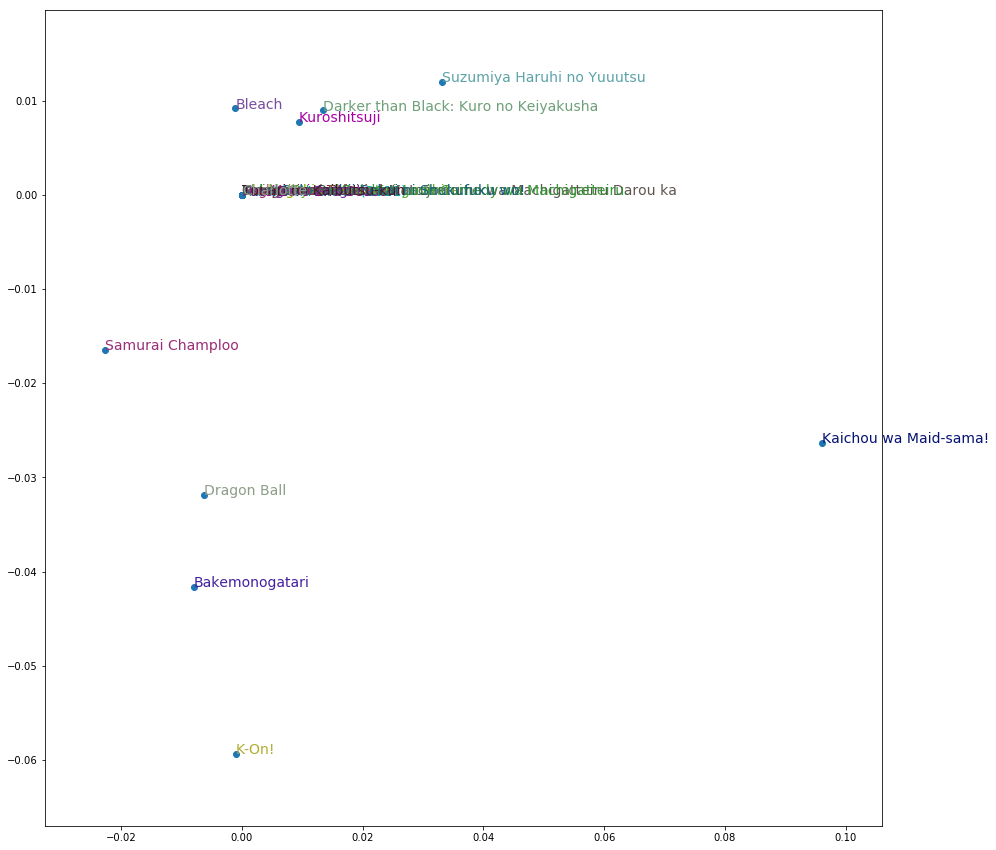

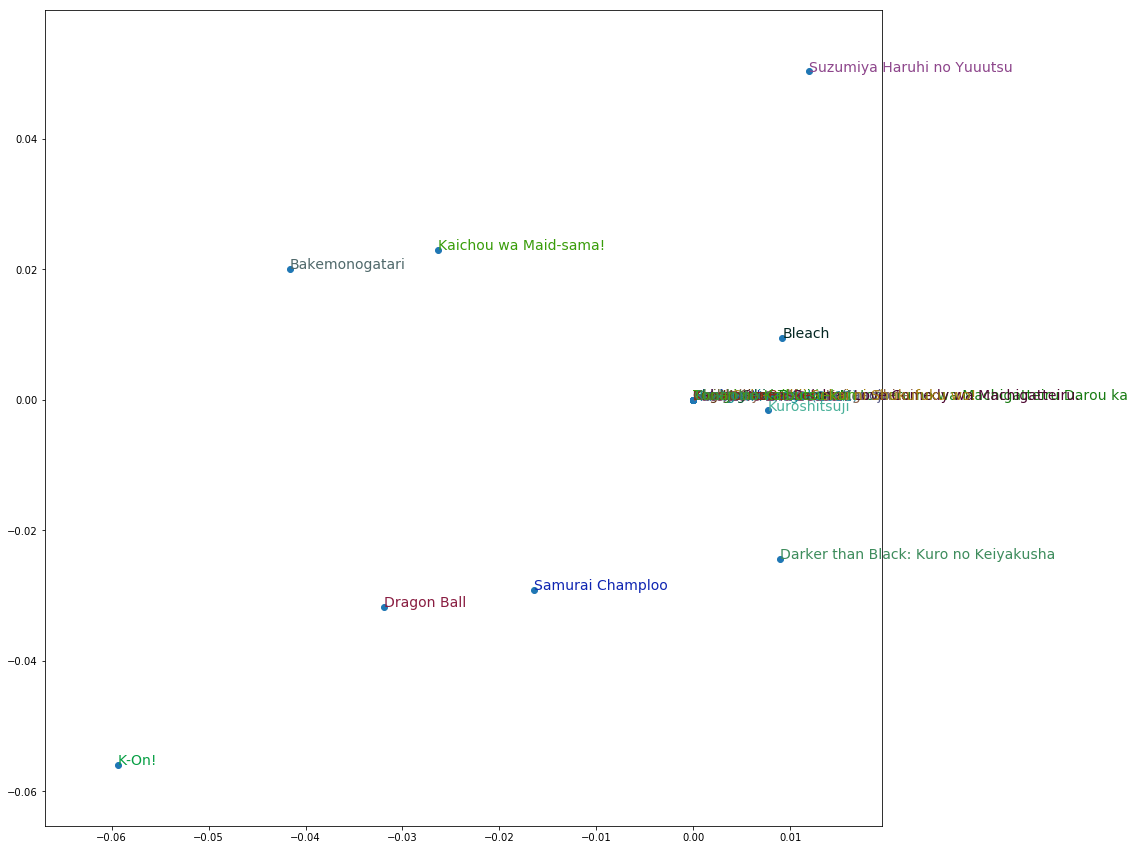

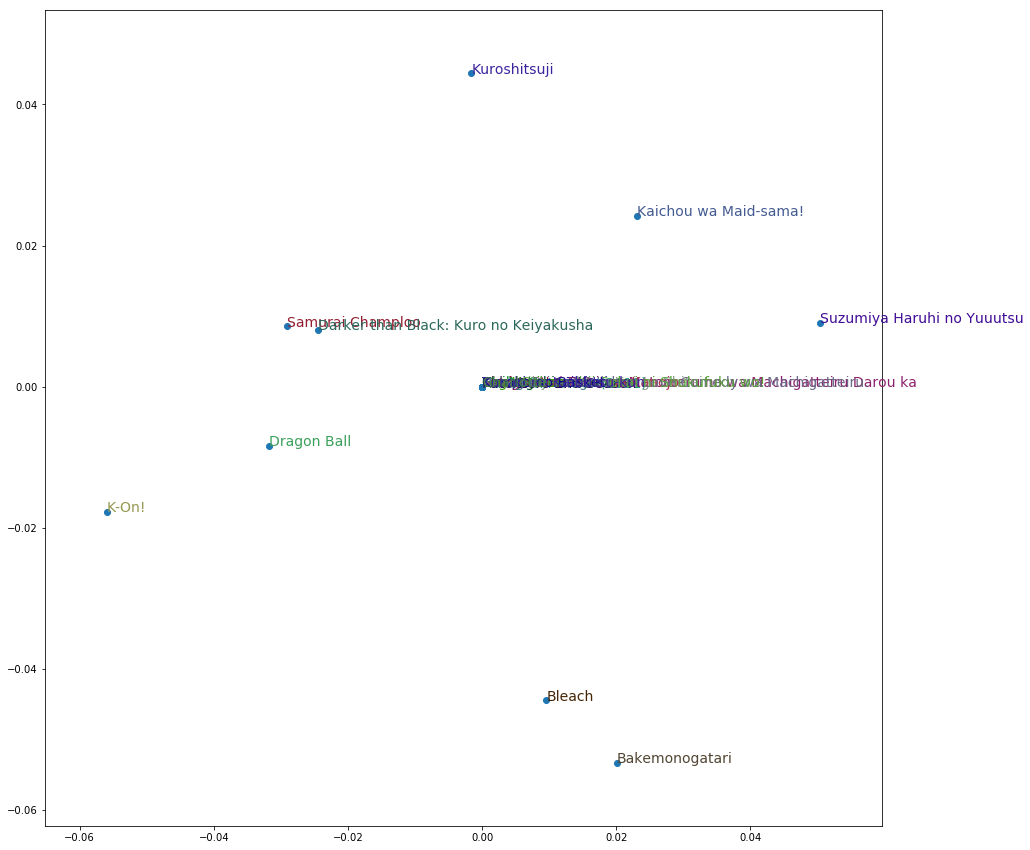

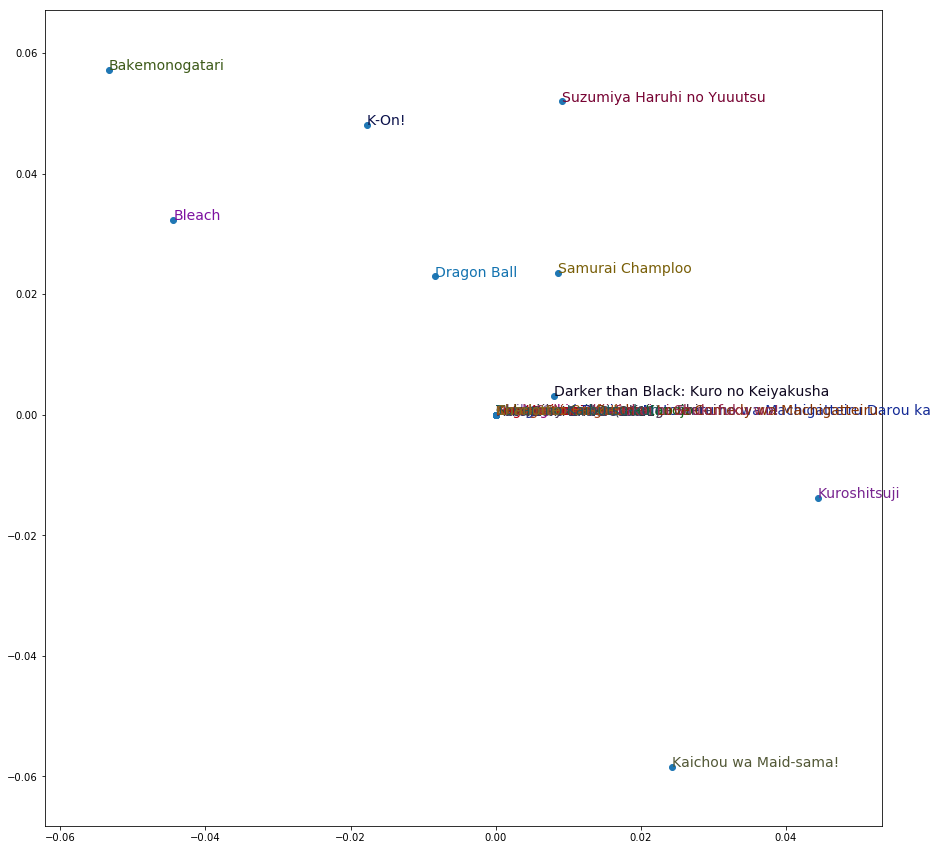

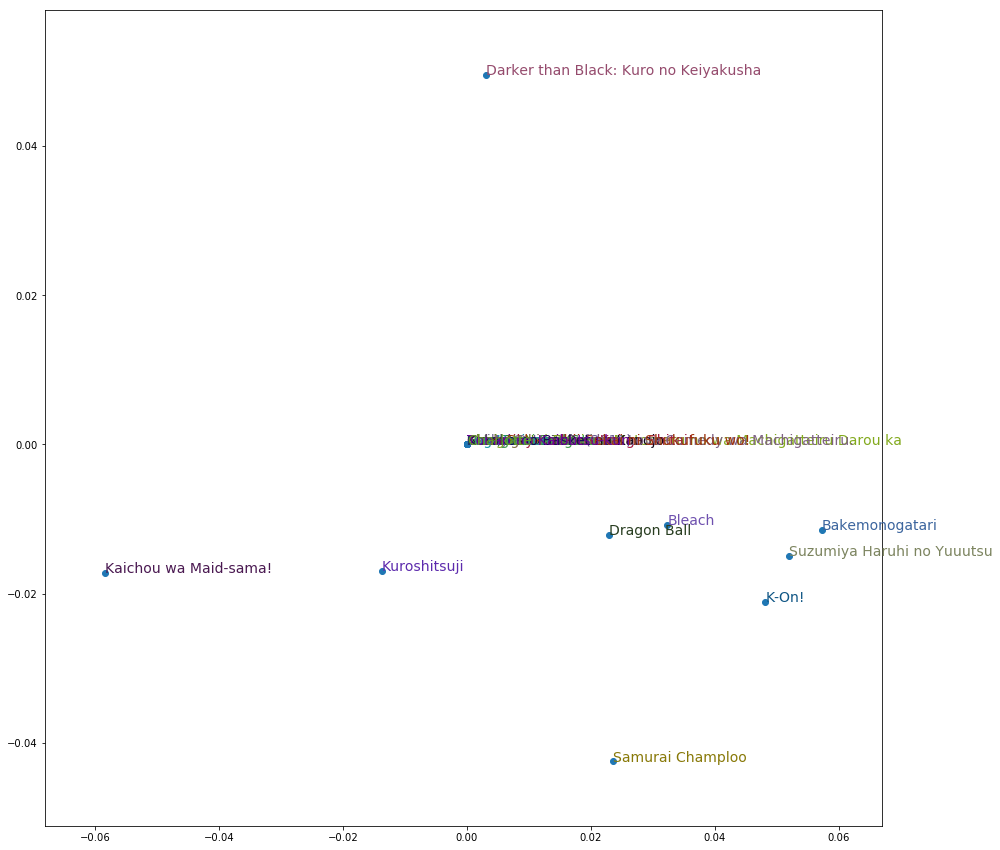

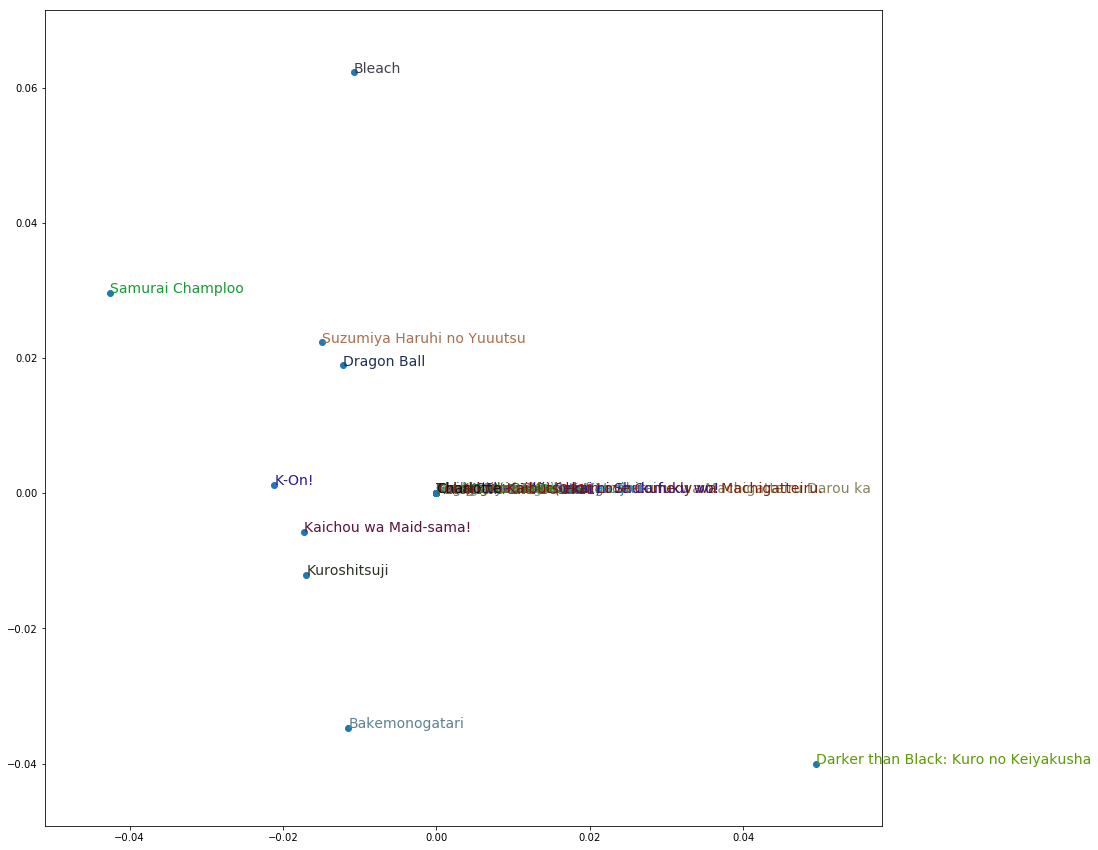

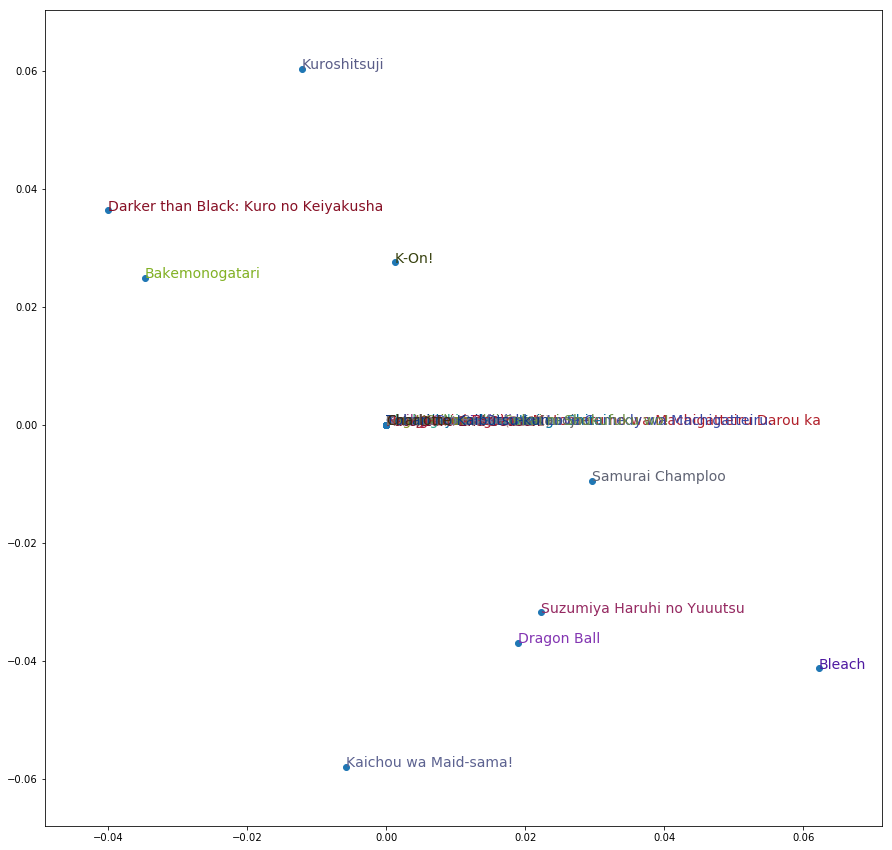

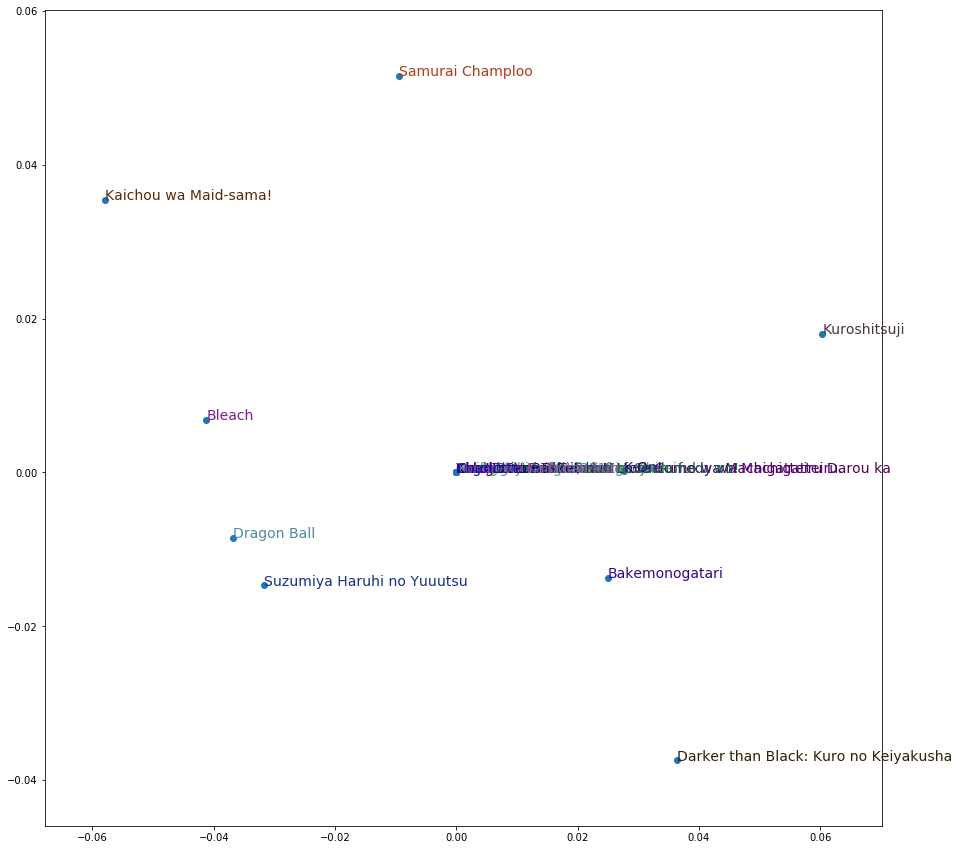

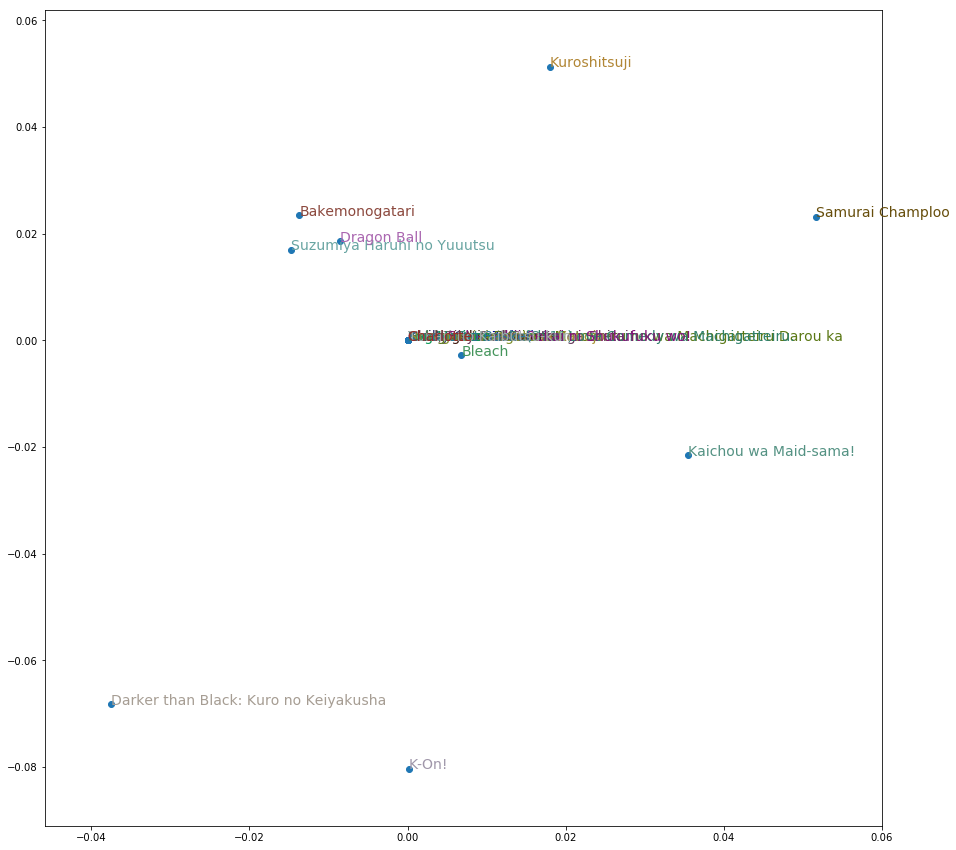

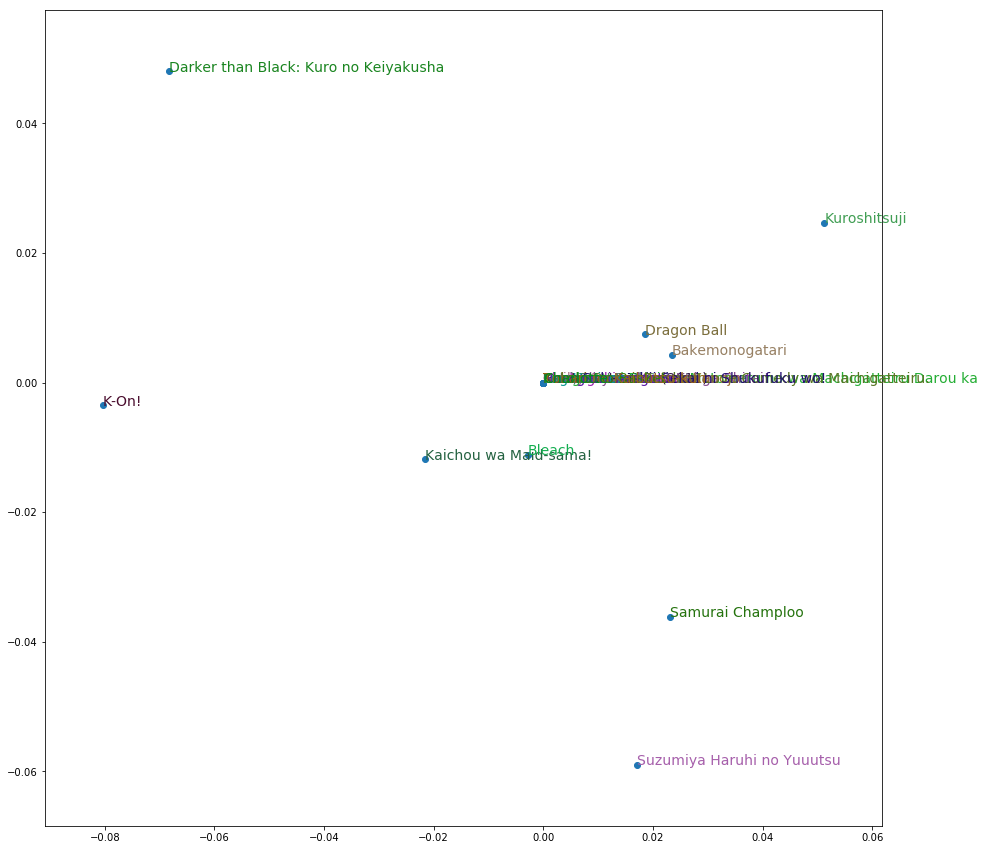

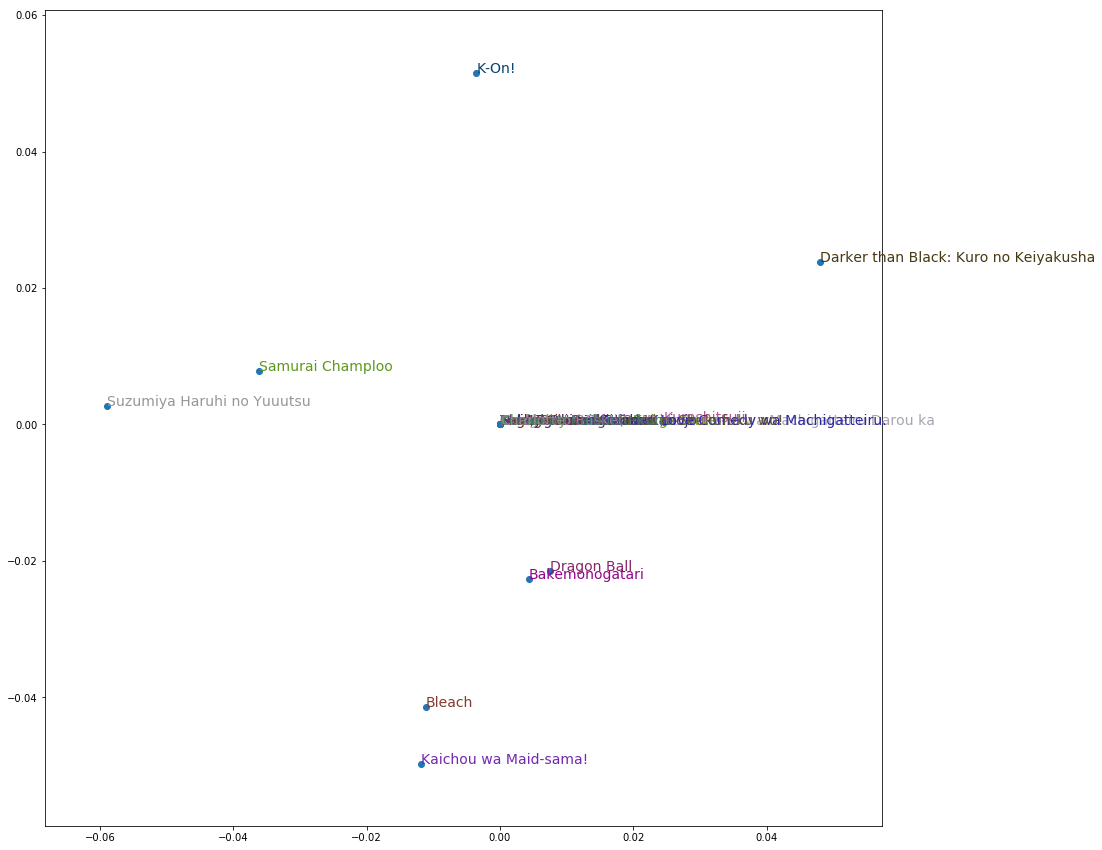

IndexError: index 12 is out of bounds for axis 0 with size 12

In [243]:
%matplotlib inline
import matplotlib.pyplot as plt
for comp in range(15):
    fac1= anime_pca2[comp]
    fac2= anime_pca2[comp+1]
    #anime_comp = [(f, anime_names[animes[animeid2idx[i]]]) for f,i in zip(fac, topAnime)]
    start=50; end=75
    X = fac1[start:end]
    Y = fac2[start:end]
    plt.figure(figsize=(15,15))
    plt.scatter(X, Y)
    for i, x, y in zip(topAnime[start:end], X, Y):
        plt.text(x,y,anime_names[animes[animeid2idx[i]]], color=np.random.rand(3)*0.7, fontsize=14)
    plt.show()
    #plt.plot()
    #print('component'+str(comp)+' top')
    #print('\n')
    #print(sorted(anime_comp, reverse=True)[:10])
    #print('\n')
    #print('component'+str(comp)+' bottom')
    #print('\n')
    #print(sorted(anime_comp)[:10])
    print('\n')

In [ ]:
kmc2= AgglomerativeClustering(n_clusters=12, affinity='cosine', linkage='average')
kmc3= AgglomerativeClustering(n_clusters=12, affinity='cosine', linkage='average')

In [ ]:
scaledweights2= ss2.fit_transform(anime_emb2)
scaledweights3= ss2.fit_transform(anime_pca2)

In [ ]:
kmc2.fit(scaledweights2)
kmc3.fit(scaledweights3)

In [ ]:
klabels2= kmc2.labels_

In [ ]:
klabels3= kmc3.labels_

In [ ]:
klabels3

In [ ]:
animu_cluster2 =pd.read_csv('animeinfo3.csv')

In [ ]:
animu_cluster2['kmeanscluster']='na'

In [ ]:
animu_cluster3 =pd.read_csv('animeinfo3.csv')

In [ ]:
animu_cluster3['kmeanscluster']='na'

In [ ]:
for animeclusternum in range(len(topAnime)):
    animenum = animes[animeid2idx[topAnime[animeclusternum]]]
    print(klabels2[animeclusternum])
    print(anime_names[animes[animeid2idx[topAnime[animeclusternum]]]])
    animu_cluster2.loc[(animu_cluster2['animeid']==animenum),['kmeanscluster']]=klabels2[animeclusternum]

In [ ]:
for animeclusternum in range(len(topAnime)):
    animenum = animes[animeid2idx[topAnime[animeclusternum]]]
    print(klabels3[animeclusternum])
    print(anime_names[animes[animeid2idx[topAnime[animeclusternum]]]])
    animu_cluster3.loc[(animu_cluster3['animeid']==animenum),['kmeanscluster']]=klabels3[animeclusternum]